In [1]:
# -*- coding: utf-8 -*-
# --- Cell 1: Imports and Helper Functions ---

import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, timezone, timedelta
import pytz
import traceback
import random
from scipy import stats
from scipy.signal import find_peaks # For peak finding in flattened spectra


# --- Import FOOOF ---
try:
    from fooof import FOOOF
    from fooof.bands import Bands
    from fooof.sim.gen import gen_aperiodic # For generating aperiodic fits
    print(f"Successfully imported 'FOOOF' class, 'Bands', and 'gen_aperiodic'.")
except ImportError as e:
    print(f"ERROR: Could not import 'FOOOF': {e}"); sys.exit()
except Exception as e:
    print(f"An unexpected error occurred during FOOOF import: {e}"); sys.exit()

# --- Helper Function to add metrics text to plots ---
def add_metrics_to_plot(ax, fm_obj, fit_type="", model_choice=None, best_model_flag=False):
    """Adds aperiodic parameters and fit metrics to the top-right of a FOOOF plot.
       bbox facecolor changes based on whether it's the 'best_model_flag'.
    """
    if not fm_obj or not fm_obj.has_model:
        line1 = f"Model: {fit_type or 'N/A'}"
        if model_choice:
            line1 = f"Best: NoFit ({model_choice})"
        text_str = f"{line1}\nAP: NaN\nFit: R2=NaN, Err=NaN"
        ax.text(0.98, 0.98, text_str, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.3', fc='lightcoral', alpha=0.75))
        return

    ap_params = fm_obj.aperiodic_params_
    r_sq = fm_obj.r_squared_
    err = fm_obj.error_
    mode = fm_obj.aperiodic_mode

    if model_choice == "NoFit":
        bg_color = 'lightcoral'
    elif best_model_flag:
        bg_color = 'lightgreen'
    else:
        bg_color = 'wheat'

    line1 = f"Model: {model_choice}" if model_choice else f"Type: {fit_type}"
    line1 += f" (Mode: {mode})"

    line2 = "AP: "
    if mode == 'fixed' and len(ap_params) == 2:
        line2 += f"Off={ap_params[0]:.2f}, Exp={ap_params[1]:.2f}"
    elif mode == 'knee' and len(ap_params) == 3:
        offset_label = "Off"; knee_label = "Knee"; exp_label = "Exp"
        knee_status = ""
        if hasattr(fm_obj, 'freqs') and fm_obj.freqs is not None and len(fm_obj.freqs) > 0:
            f_min_analysis = fm_obj.freq_range[0]
            if ap_params[1] < (f_min_analysis + 2) or (len(ap_params) > 2 and abs(ap_params[2]) < 0.1):
                 knee_status = " (Knee?)"
        line2 += f"{offset_label}={ap_params[0]:.2f}, {knee_label}={ap_params[1]:.1f}, {exp_label}={ap_params[2]:.2f}{knee_status}"
    else:
        line2 += f"Params={np.round(ap_params, 2)}"

    line3 = f"Fit: R2={r_sq:.3f}, Err={err:.2e}"
    text_str = f"{line1}\n{line2}\n{line3}"
    ax.text(0.98, 0.98, text_str, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', fc=bg_color, alpha=0.75))

# Matplotlib settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

print("Cell 1: Imports and helper functions defined.")

# --- Prompt user for subject ID (Patient ID) ---
# For development, hardcoded; can replace with input() for interactive use
# subject_id_input = input("Enter subject ID (e.g., RCS08R or RCS20 for RCS20R/L): ").strip().upper()
# For example, if file is RCS20R_data.csv, subject_id_input might be "RCS20R"
# Or if we want to process RCS20L and RCS20R, the script might loop or take specific patient-hemi
subject_id_input = "RCS02L" # Example: This should be the patient-hemisphere ID
print(f"User specified subject-hemisphere ID: {subject_id_input}")
session_id = subject_id_input # session_id in this script context refers to the patient-hemisphere identifier

project_base_path = "/home/jackson"

# --- End of Cell 1 ---

Successfully imported 'FOOOF' class, 'Bands', and 'gen_aperiodic'.
Cell 1: Imports and helper functions defined.
User specified subject-hemisphere ID: RCS02L


/tmp/ipykernel_941856/2426868276.py:21: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
!pwd

/home/jackson


In [3]:
# -*- coding: utf-8 -*-
# --- Cell 2: Configuration ---

import os
import pandas as pd
from fooof import FOOOF # To print settings if needed
import numpy as np # Required for np.inf

# -----------------------------------------------------------------------------
# Path Configuration
# -----------------------------------------------------------------------------
try:
    # This assumes the notebook is in a 'scripts' or similar folder
    current_script_path = os.path.dirname(os.path.abspath(__file__)) # For .py
except NameError:
    current_script_path = os.getcwd() # For .ipynb

print(f"Project base path determined as: {project_base_path}")

# --- Input Data Paths (derived from project_base_path and session_id from Cell 1) ---
# session_id is patient-hemisphere, e.g., "RCS20R"
patient_code = session_id[:-1] # e.g., "RCS20"
hemisphere_code_short = session_id[-1] # e.g., "R"
hemisphere_long = "Right" if hemisphere_code_short == "R" else "Left" if hemisphere_code_short == "L" else "UnknownHemi"
step2_output_folder_name = f"step2_preprocessed_data_120s_neural_aligned_{patient_code}{hemisphere_code_short}_{hemisphere_long}_AllSessions_newnaming_tester_left"
step2_output_path = os.path.join(project_base_path, step2_output_folder_name)
print(f"Expecting Step 2 output CSV/JSON files in: {step2_output_path}")


# --- Output Configuration ---
output_version_tag = "neural_pkg_aligned" # Updated tag
fooof_output_folder_py_base = os.path.join(project_base_path, f'step3_fooof_results_{output_version_tag}')
if not os.path.exists(fooof_output_folder_py_base):
    os.makedirs(fooof_output_folder_py_base)
    print(f"Created base output folder for new FOOOF results: {fooof_output_folder_py_base}")
else:
    print(f"Base output folder for new FOOOF results: {fooof_output_folder_py_base}")

# --- Analysis Setup (Defaults, will be refined by loaded params_for_python.json or CSV) ---
freq_ranges_default = {
    'LowFreq': [10, 40],
    'MidFreq': [30, 90],
    'WideFreq': [10, 90] # This is our default for Q1 and Q3 if C(FreqRangeLabel) is not used
}
channels_to_process_default = []
electrode_labels_default = {}
neural_hemisphere_default = hemisphere_long
target_neural_segment_duration_default = 120.0
pkg_interpolation_interval_default = 30.0

# --- FOOOF Settings (MODIFIED AS PER YOUR REQUEST in original script) ---
common_new_fooof_params = {
    'peak_width_limits': [2.0, 8.0],
    'max_n_peaks': np.inf,
    'min_peak_height': 0.0,
    'peak_threshold': 2.0,
    'verbose': False
}
basic_fooof_settings = {**common_new_fooof_params, 'aperiodic_mode': 'fixed'}
knee_fooof_settings = {**common_new_fooof_params, 'aperiodic_mode': 'knee'}

print("\n--- Basic FOOOF Settings (Fixed Mode) - UPDATED ---")
FOOOF(**basic_fooof_settings).print_settings()
print("\n--- Advanced FOOOF Settings (Knee Mode) - UPDATED ---")
FOOOF(**knee_fooof_settings).print_settings()


# --- NEW: Beta/Gamma Peak Feature Extraction Parameters ---
BETA_BAND = [13, 30]  # Hz
GAMMA_BAND = [60, 90] # Hz
BETA_BASELINE_FREQ_REGION = [10, 12] # Hz region to calculate baseline flat power for beta peaks
GAMMA_BASELINE_FREQ_REGION = [55, 59] # Hz region to calculate baseline flat power for gamma peaks
PEAK_SIG_SD_THRESHOLD = 1.0 # SDs above baseline region mean in flattened spectrum for a peak to be considered

# --- Define Master Table Columns ---
# UPDATED to include new metrics
master_table_columns = [
    'SessionID', 'Hemisphere', 'Channel', 'ElectrodeLabel',
    'Neural_Segment_Start_Unixtime', 'Neural_Segment_End_Unixtime',
    'Neural_Segment_Duration_Sec',
    'FS',
    'PSD_Data_Str', 'Frequency_Vector_Str',
    'Aligned_PKG_UnixTimestamp', 'Aligned_PKG_DateTime_Str', 'Clinical_State_2min_Window',
    'Aligned_BK', 'Aligned_DK', 'Aligned_Tremor_Score', 'Aligned_Tremor',
    # NEW Metrics
    'Total_Daily_LEDD_mg',
    'Beta_Peak_Power_at_DominantFreq',
    'Gamma_Peak_Power_at_DominantFreq',
    # FOOOF Results
    'FreqRangeLabel', 'FreqLow', 'FreqHigh',
    'BestModel_AperiodicMode',
    'Offset_BestModel', 'Knee_BestModel', 'Exponent_BestModel',
    'R2_BestModel', 'Error_BestModel', 'Num_Peaks_BestModel',
    'Offset_Fixed', 'Exponent_Fixed',
    'R2_Fixed', 'Error_Fixed', 'Num_Peaks_Fixed',
    'Offset_Knee', 'Knee_Knee', 'Exponent_Knee',
    'R2_Knee', 'Error_Knee', 'Num_Peaks_Knee',
    'ErrorMsg_FOOOF'
]
# fooof_object_columns = ['fm_fixed_obj', 'fm_knee_obj'] # No longer saving full FOOOF objects to master CSV

# --- Plotting Configuration for Visualization Cells ---
NUM_REPRESENTATIVE_SEGMENTS_PER_CHANNEL = 3
APERIODIC_PLOT_TIME_BIN_MINUTES = 30
HOURLY_AVG_FREQ = 'H'
THIRTY_MIN_AVG_FREQ = '30T' # or '30min'
BOXPLOT_PALETTE = "Set2"
HISTOGRAM_BINS = 50

REFINED_MOBILE_STATES = ['Dyskinetic Mobile', 'Non-Dyskinetic Mobile', 'Transitional Mobile']
AGGREGATED_MOBILE_NAME = 'Mobile (All Types)'


print("\nCell 2: Configuration complete with updated FOOOF settings and new metric parameters.")
# --- End of Cell 2 ---

Project base path determined as: /home/jackson
Expecting Step 2 output CSV/JSON files in: /home/jackson/step2_preprocessed_data_120s_neural_aligned_RCS02L_Left_AllSessions_newnaming_tester_left
Base output folder for new FOOOF results: /home/jackson/step3_fooof_results_neural_pkg_aligned

--- Basic FOOOF Settings (Fixed Mode) - UPDATED ---
                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                  Peak Width Limits : [2.0, 8.0]                                  
                                    Max Number of Peaks : inf                                     
                                    Minimum Peak Height : 0.0                                     
                                       Peak Threshold: 2.0      

In [4]:
# -*- coding: utf-8 -*-
# --- Cell 3: Load Parameters and Data from CSV & JSON, Calculate Daily LEDD ---

import json
import numpy as np
import pandas as pd
import os
import sys
import pytz
import re # Import regular expressions for parsing
from datetime import datetime, timezone, time

# --- Initialize with defaults (from Cell 2) ---
params_from_matlab = {}
loaded_freq_ranges = freq_ranges_default.copy()
neural_hemisphere = neural_hemisphere_default # Derived from session_id in Cell 2
target_neural_segment_duration = target_neural_segment_duration_default
pkg_interpolation_interval = pkg_interpolation_interval_default

# --- Construct expected filenames and paths (session_id is patient-hemisphere from Cell 1) ---
target_csv_filename = f"Step2_Aligned120sPSDs_{session_id}_Left_AllSessions.csv"
params_json_filename = f"Step2_params_120sPSDs_{session_id}_Left_AllSessions.json"

csv_file_path = os.path.join(step2_output_path, target_csv_filename)
params_json_path = os.path.join(step2_output_path, params_json_filename)

# --- Check if files exist ---
if not os.path.exists(csv_file_path):
    print(f"ERROR: Main data CSV file not found at {csv_file_path}. Cannot proceed.")
    sys.exit()
print(f"\nTarget CSV file: {target_csv_filename}")

if not os.path.exists(params_json_path):
    print(f"Warning: Parameters JSON file not found at {params_json_path}. Using defaults for freq_ranges, segment durations.")
else:
    print(f"Target JSON_params file: {params_json_filename}")

# --- Load Main Data from Step 2 CSV file ---
fooof_input_df = pd.DataFrame()
try:
    fooof_input_df = pd.read_csv(csv_file_path)
    print(f"Successfully loaded CSV from Step 2. Shape: {fooof_input_df.shape}")
    if fooof_input_df.empty:
        print("ERROR: Loaded CSV is empty. Cannot proceed.")
        sys.exit()

    # Use session_id (patient-hemisphere) from Cell 1 for consistency
    fooof_input_df['SessionID_original_from_csv'] = fooof_input_df.get('PatientID', session_id) # Keep original if exists
    fooof_input_df['SessionID'] = session_id # This is patient-hemisphere like RCS20R

    if 'Hemisphere' in fooof_input_df.columns and not fooof_input_df['Hemisphere'].isnull().all():
        csv_hemisphere = fooof_input_df['Hemisphere'].dropna().iloc[0] if not fooof_input_df['Hemisphere'].dropna().empty else neural_hemisphere_default
        if csv_hemisphere.lower() != neural_hemisphere.lower(): # neural_hemisphere from Cell 2 (via session_id)
            print(f"Warning: Hemisphere in CSV ({csv_hemisphere}) differs from expected based on session_id ({neural_hemisphere}). Using value from session_id.")
        fooof_input_df['Hemisphere'] = neural_hemisphere
    else:
        print("Warning: 'Hemisphere' column not found or empty in CSV. Assigning based on session_id.")
        fooof_input_df['Hemisphere'] = neural_hemisphere

except Exception as e:
    print(f"ERROR: Could not load or parse CSV file {csv_file_path}: {e}")
    print(traceback.format_exc())
    sys.exit()

# --- Load Parameters from JSON file (if found) ---
electrode_info_matlab = {}
if os.path.exists(params_json_path):
    print(f"\nLoading parameters from JSON: {params_json_path}")
    try:
        with open(params_json_path, 'r') as f:
            params_from_matlab = json.load(f)
        print("Parameters JSON loaded successfully.")
        loaded_freq_ranges = params_from_matlab.get('freq_ranges_defined_for_fooof', loaded_freq_ranges)
        electrode_info_matlab = params_from_matlab.get('electrode_info_used', {})
        target_neural_segment_duration = params_from_matlab.get('target_neural_segment_duration_sec', target_neural_segment_duration)
        # ... (other params as in original script) ...
    except Exception as e:
        print(f"ERROR: Could not load or parse parameters JSON file {params_json_path}: {e}")
else:
    print(f"\nParameters JSON file not found at {params_json_path}. Using defaults.")

ITERATIVE_FREQ_BANDS = loaded_freq_ranges
print(f"\nUsing Session ID (Patient-Hemisphere): {session_id}")
print(f"Using Hemisphere: {neural_hemisphere}")
print(f"Using freq_ranges for FOOOF: {ITERATIVE_FREQ_BANDS}")

# --- Create dynamic Output Folders ---
session_specific_output_folder = os.path.join(fooof_output_folder_py_base, str(session_id), str(neural_hemisphere))
visualization_folder_session_specific = os.path.join(session_specific_output_folder, 'visualizations_step3')
aperiodic_plot_output_folder_base = visualization_folder_session_specific
FIGURES_OUTPUT_PATH_NEW_CELLS = os.path.join(session_specific_output_folder, 'new_analysis_figures') # For Cell 5a,b,c plots
DATA_OUTPUT_PATH_NEW_CELLS = os.path.join(session_specific_output_folder, 'new_analysis_data') # For Cell 4b outputs
for folder_path in [session_specific_output_folder, visualization_folder_session_specific, FIGURES_OUTPUT_PATH_NEW_CELLS, DATA_OUTPUT_PATH_NEW_CELLS]:
    if not os.path.exists(folder_path): os.makedirs(folder_path)
print(f"Step 3 session-specific outputs will be in: {session_specific_output_folder}")

master_csv_filename_patient = f"MASTER_FOOOF_PKG_results_{session_id}_{output_version_tag}.csv"
master_csv_path_patient_specific = os.path.join(fooof_output_folder_py_base, master_csv_filename_patient)
print(f"Master results CSV for {session_id} will be saved/updated at: {master_csv_path_patient_specific}")

# --- Parse PSD_Data and Frequency_Vector ---
def parse_float_string(s):
    try: return np.array(s.split(';'), dtype=float)
    except: return np.array([]) # return empty if error

if 'PSD_Data_Str' in fooof_input_df.columns:
    fooof_input_df['PSD_Data'] = fooof_input_df['PSD_Data_Str'].apply(parse_float_string) # Linear power
    print("Parsed 'PSD_Data_Str' into numpy arrays.")
else:
    print("ERROR: 'PSD_Data_Str' column not found. Cannot run FOOOF."); sys.exit()

if 'Frequency_Vector_Str' in fooof_input_df.columns:
    fooof_input_df['Frequency_Vector_Raw'] = fooof_input_df['Frequency_Vector_Str'].apply(parse_float_string)
    print("Parsed 'Frequency_Vector_Str' into numpy arrays (as Frequency_Vector_Raw).")
else:
    print("ERROR: 'Frequency_Vector_Str' column not found. Cannot run FOOOF."); sys.exit()

# --- Add/Verify Neural_Segment_Duration_Sec & DateTime columns ---
# ... (rest of original Cell 3 for duration, datetime, electrode labels, channels to process) ...
if 'Neural_Segment_Duration_Sec' not in fooof_input_df.columns:
    if 'Neural_Segment_Start_Unixtime' in fooof_input_df.columns and 'Neural_Segment_End_Unixtime' in fooof_input_df.columns:
        fooof_input_df['Neural_Segment_Duration_Sec'] = fooof_input_df['Neural_Segment_End_Unixtime'] - fooof_input_df['Neural_Segment_Start_Unixtime']
        print("Derived 'Neural_Segment_Duration_Sec' from timestamps.")
    # ... (verification against target_neural_segment_duration) ...
else:
    fooof_input_df['Neural_Segment_Duration_Sec'] = pd.to_numeric(fooof_input_df['Neural_Segment_Duration_Sec'], errors='coerce')

# Add readable DateTime columns
if 'Neural_Segment_Start_Unixtime' in fooof_input_df.columns:
    fooof_input_df['Neural_Segment_Start_DateTime_UTC'] = pd.to_datetime(fooof_input_df['Neural_Segment_Start_Unixtime'], unit='s', utc=True, errors='coerce')
if 'Aligned_PKG_UnixTimestamp' in fooof_input_df.columns: # For clinical state alignment
    fooof_input_df['Aligned_PKG_DateTime_UTC'] = pd.to_datetime(fooof_input_df['Aligned_PKG_UnixTimestamp'], unit='s', utc=True, errors='coerce')


# Extract unique channels and their electrode labels
if 'Channel' in fooof_input_df.columns and 'ElectrodeLabel' in fooof_input_df.columns:
    unique_channels_df = fooof_input_df[['Channel', 'ElectrodeLabel']].drop_duplicates().set_index('Channel')
    electrode_labels = unique_channels_df['ElectrodeLabel'].to_dict()
    print(f"Derived electrode_labels from CSV: {electrode_labels}")
    channels_to_process = list(electrode_labels.keys())
    print(f"Channels to process based on CSV: {channels_to_process}")
else:
    print("Warning: 'Channel' or 'ElectrodeLabel' columns not found. Plotting labels might be generic.")
    channels_to_process = list(fooof_input_df['Channel'].unique()) if 'Channel' in fooof_input_df.columns else []
    if not electrode_labels and channels_to_process:
        electrode_labels = {ch: ch for ch in channels_to_process}


print(f"\nSample of fooof_input_df head after initial processing (first 2 rows):")
print(fooof_input_df.head(2))
print(f"Columns in fooof_input_df: {fooof_input_df.columns.tolist()}")

print("\nCell 3: Data loading, initial parsing, and Daily LEDD calculation complete.")
# --- End of Cell 3 ---


Target CSV file: Step2_Aligned120sPSDs_RCS02L_Left_AllSessions.csv
Target JSON_params file: Step2_params_120sPSDs_RCS02L_Left_AllSessions.json
Successfully loaded CSV from Step 2. Shape: (18696, 15)

Loading parameters from JSON: /home/jackson/step2_preprocessed_data_120s_neural_aligned_RCS02L_Left_AllSessions_newnaming_tester_left/Step2_params_120sPSDs_RCS02L_Left_AllSessions.json
Parameters JSON loaded successfully.

Using Session ID (Patient-Hemisphere): RCS02L
Using Hemisphere: Left
Using freq_ranges for FOOOF: {'LowFreq': [10, 40], 'MidFreq': [30, 90], 'WideFreq': [10, 90]}
Step 3 session-specific outputs will be in: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left
Master results CSV for RCS02L will be saved/updated at: /home/jackson/step3_fooof_results_neural_pkg_aligned/MASTER_FOOOF_PKG_results_RCS02L_neural_pkg_aligned.csv
Parsed 'PSD_Data_Str' into numpy arrays.
Parsed 'Frequency_Vector_Str' into numpy arrays (as Frequency_Vector_Raw).
Derived 'Neural_Segment_

In [5]:
# -*- coding: utf-8 -*-
# Assume pandas as pd and numpy as np are imported
# Assume session_id is defined
# Define REFINED_MOBILE_STATES and AGGREGATED_MOBILE_NAME
REFINED_MOBILE_STATES = ["Dyskinetic Mobile", "Non-Dyskinetic Mobile", "Transitional Mobile"]
AGGREGATED_MOBILE_NAME = "Mobile (All Types)"

print("\n--- Cell 3a: Clinical State Derivation (Point-by-Point Method) ---")

if 'fooof_input_df' not in locals() or fooof_input_df.empty:
    print("fooof_input_df is empty or not defined. Skipping state derivation.")
    if 'fooof_input_df' in locals() and not fooof_input_df.empty:
        fooof_input_df['Clinical_State_2min_Window'] = "StateProcessingError"
        fooof_input_df['Clinical_State_Aggregated'] = "StateProcessingError"
else:
    required_pkg_cols = ['Aligned_BK', 'Aligned_DK', 'Aligned_PKG_UnixTimestamp']
    if not all(col in fooof_input_df.columns for col in required_pkg_cols):
        print(f"ERROR: Missing one or more required PKG columns: {required_pkg_cols}")
        fooof_input_df['Clinical_State_2min_Window'] = "DataMissingForPKGState"
        fooof_input_df['Clinical_State_Aggregated'] = "DataMissingForPKGState"
    else:
        # Ensure PKG scores are numeric
        fooof_input_df['Aligned_BK'] = pd.to_numeric(fooof_input_df['Aligned_BK'], errors='coerce')
        fooof_input_df['Aligned_DK'] = pd.to_numeric(fooof_input_df['Aligned_DK'], errors='coerce')

        # --- Step 1: Calculate DK Percentiles for Mobile Candidates ---
        # Define general mobile candidates based on BK <= 26 OR DK >= 7
        is_general_mobile_candidate = (
            (fooof_input_df['Aligned_BK'] <= 26) | 
            (fooof_input_df['Aligned_DK'] >= 7)
        )
        
        # Get DK scores for mobile candidates only
        mobile_candidate_dk_scores = fooof_input_df.loc[
            is_general_mobile_candidate & fooof_input_df['Aligned_DK'].notna(), 
            'Aligned_DK'
        ]
        
        if len(mobile_candidate_dk_scores) > 1:
            p30_dk = np.percentile(mobile_candidate_dk_scores, 30)
            p70_dk = np.percentile(mobile_candidate_dk_scores, 70)
            print(f"  DK percentiles for mobile candidates: 30th={p30_dk:.2f}, 70th={p70_dk:.2f}")
        else:
            print("  Warning: Not enough mobile candidate data to calculate DK percentiles.")
            p30_dk = -np.inf
            p70_dk = np.inf

        # --- Step 2: Apply Point-by-Point State Assignment ---
        # This method assigns states based on individual PKG values at each timepoint
        def assign_clinical_state_point(row):
            """
            Assigns clinical state based on PKG scores at a single timepoint.
            This is a point-by-point method without temporal windowing.
            """
            bk = row['Aligned_BK']
            dk = row['Aligned_DK']
            
            if pd.isna(bk) or pd.isna(dk):
                return "Other"
            
            # Sleep state: BK >= 80
            if bk >= 80:
                return "Sleep"
            
            # Immobile state: BK > 26 AND BK < 80 AND DK < 7
            elif (bk > 26) and (bk < 80) and (dk < 7):
                return "Immobile"
            
            # Mobile states: BK <= 26 OR DK >= 7
            elif (bk <= 26) or (dk >= 7):
                # Subdivide mobile states based on DK percentiles
                if pd.notna(p30_dk) and pd.notna(p70_dk):
                    if dk <= p30_dk:
                        return "Non-Dyskinetic Mobile"
                    elif dk > p70_dk:
                        return "Dyskinetic Mobile"
                    else:  # p30_dk < dk <= p70_dk
                        return "Transitional Mobile"
                else:
                    # If percentiles couldn't be calculated, use generic mobile
                    return "Mobile (Generic)"
            
            else:
                return "Other"


        # Apply the state assignment function to each row
        fooof_input_df['Clinical_State_2min_Window'] = fooof_input_df.apply(
            assign_clinical_state_point, axis=1
        )
        # After assigning Clinical_State_2min_Window
        mask_other = fooof_input_df['Clinical_State_2min_Window'] == "Other"
        if mask_other.any():
            # Reason tags
            reasons = np.where(
                fooof_input_df.loc[mask_other, 'Aligned_BK'].isna() & fooof_input_df.loc[mask_other, 'Aligned_DK'].isna(),
                'BK & DK missing',
                np.where(
                    fooof_input_df.loc[mask_other, 'Aligned_BK'].isna(),
                    'BK missing',
                    np.where(fooof_input_df.loc[mask_other, 'Aligned_DK'].isna(), 'DK missing', 'Rule fallback')
                )
            )
            fooof_input_df.loc[mask_other, 'Other_Reason'] = reasons
        
            # Print a compact report
            print("\n  'Other' classification diagnostics:")
            print(fooof_input_df.loc[mask_other, ['Aligned_PKG_UnixTimestamp','Channel','ElectrodeLabel','Aligned_BK','Aligned_DK','Other_Reason']])
        
            print("\n  'Other' breakdown:")
            print(fooof_input_df.loc[mask_other, 'Other_Reason'].value_counts())
        else:
            print("\n  No rows classified as 'Other'.")

        # 🔍 NEW: Print all rows classified as "Other"
        other_rows = fooof_input_df[fooof_input_df['Clinical_State_2min_Window'] == "Other"]
        if not other_rows.empty:
            print(f"\n  Found {len(other_rows)} rows classified as 'Other':")
            print(other_rows)
        else:
            print("\n  No rows classified as 'Other'.")

        
        print(f"  Assigned clinical states using point-by-point method.")
        print(f"  Note: Column is named 'Clinical_State_2min_Window' for compatibility,")
        print(f"        but uses instantaneous PKG values, not temporal windowing.")

        # --- Step 3: Create Aggregated Clinical States ---
        # Group all refined mobile states into one category
        def create_aggregated_state(state):
            """
            Aggregates refined mobile states into a single 'Mobile (All Types)' category.
            Non-mobile states remain unchanged.
            """
            if state in REFINED_MOBILE_STATES:
                return AGGREGATED_MOBILE_NAME
            elif state == "Mobile (Generic)":
                # Also aggregate the generic mobile fallback
                return AGGREGATED_MOBILE_NAME
            else:
                return state

        fooof_input_df['Clinical_State_Aggregated'] = fooof_input_df['Clinical_State_2min_Window'].apply(
            create_aggregated_state
        )

        # --- Step 4: Display Results ---
        print("\n  Clinical state distribution (Clinical_State_2min_Window):")
        print(fooof_input_df['Clinical_State_2min_Window'].value_counts(dropna=False))
        
        print("\n  Aggregated clinical state distribution:")
        print(fooof_input_df['Clinical_State_Aggregated'].value_counts(dropna=False))

        # --- Step 5: Verify Data Integrity ---
        n_missing_states = fooof_input_df['Clinical_State_2min_Window'].isna().sum()
        if n_missing_states > 0:
            print(f"\n  Warning: {n_missing_states} rows have missing clinical states.")

# Define clinical state colors for plotting
CLINICAL_STATE_COLORS = {
    'Sleep': '#4169E1',                 # RoyalBlue
    'Immobile': '#40E0D0',              # Turquoise
    'Non-Dyskinetic Mobile': '#32CD32', # LimeGreen
    'Transitional Mobile': '#FFD700',   # Gold
    'Dyskinetic Mobile': '#FF6347',     # Tomato
    'Mobile (All Types)': 'darkgreen',  # For aggregated view
    'Mobile (Generic)': 'darkgreen',    # Fallback mobile state
    'Other': '#C0C0C0',                 # Silver
    'DataMissingForPKGState': '#F5F5F5',
    'StateProcessingError': '#E0E0E0'
}

print(f"\nClinical state colors defined for plotting: {list(CLINICAL_STATE_COLORS.keys())}")
print("--- Cell 3a: Clinical State Derivation Complete ---")


--- Cell 3a: Clinical State Derivation (Point-by-Point Method) ---
  DK percentiles for mobile candidates: 30th=0.45, 70th=54.80

  No rows classified as 'Other'.

  No rows classified as 'Other'.
  Assigned clinical states using point-by-point method.
  Note: Column is named 'Clinical_State_2min_Window' for compatibility,
        but uses instantaneous PKG values, not temporal windowing.

  Clinical state distribution (Clinical_State_2min_Window):
Clinical_State_2min_Window
Sleep                    5484
Immobile                 4148
Transitional Mobile      3620
Non-Dyskinetic Mobile    2724
Dyskinetic Mobile        2720
Name: count, dtype: int64

  Aggregated clinical state distribution:
Clinical_State_Aggregated
Mobile (All Types)    9064
Sleep                 5484
Immobile              4148
Name: count, dtype: int64

Clinical state colors defined for plotting: ['Sleep', 'Immobile', 'Non-Dyskinetic Mobile', 'Transitional Mobile', 'Dyskinetic Mobile', 'Mobile (All Types)', 'Mobile (

# -*- coding: utf-8 -*-
# --- (NEW) Cell 4b: Beta/Gamma Peak Feature Extraction ---
# This cell calculates Beta_Peak_Power_at_DominantFreq and Gamma_Peak_Power_at_DominantFreq

import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import warnings

print("\n--- Cell 4b: Starting Beta/Gamma Peak Feature Extraction ---")

if 'fooof_input_df' not in locals() or fooof_input_df.empty:
    print("fooof_input_df is empty or not defined. Skipping Beta/Gamma feature extraction.")
    if 'fooof_input_df' in locals() and not fooof_input_df.empty:
        fooof_input_df['Beta_Peak_Power_at_DominantFreq'] = np.nan
        fooof_input_df['Gamma_Peak_Power_at_DominantFreq'] = np.nan
else:
    required_cols_for_cell4b = ['PSD_Data', 'Frequency_Vector_Raw', 'SessionID', 'Channel', 'ElectrodeLabel']
    if not all(col in fooof_input_df.columns for col in required_cols_for_cell4b):
        missing_cols = [col for col in required_cols_for_cell4b if col not in fooof_input_df.columns]
        print(f"ERROR: Missing required columns for Beta/Gamma extraction: {missing_cols}. Skipping.")
        fooof_input_df['Beta_Peak_Power_at_DominantFreq'] = np.nan
        fooof_input_df['Gamma_Peak_Power_at_DominantFreq'] = np.nan
    else:
        debug_plot_folder = os.path.join(visualization_folder_session_specific, 'cell4b_debug_plots')
        if not os.path.exists(debug_plot_folder):
            os.makedirs(debug_plot_folder)
        print(f"Debug plots for Cell 4b will be saved to: {debug_plot_folder}")
        
        dominant_beta_freqs_channel = {}
        dominant_gamma_freqs_channel = {}

        if 'Channel_Display' not in fooof_input_df.columns:
            if 'ElectrodeLabel' in fooof_input_df.columns and electrode_labels:
                 fooof_input_df['Channel_Display'] = fooof_input_df['Channel'].map(electrode_labels).fillna(fooof_input_df['Channel'])
            else:
                 fooof_input_df['Channel_Display'] = fooof_input_df['Channel']
        
        print("  Calculating dominant peak frequencies per channel (from flattened spectra)...")
        unique_channels_for_dom_freq = fooof_input_df['Channel'].unique()
        
        for channel_key in tqdm(unique_channels_for_dom_freq, desc="Processing Channels for Dom. Freq"):
            df_channel = fooof_input_df[fooof_input_df['Channel'] == channel_key].copy().reset_index()
            el_label_for_channel = df_channel['ElectrodeLabel'].iloc[0]

            num_segments_in_channel = len(df_channel)
            indices_to_plot = []
            if num_segments_in_channel > 0: indices_to_plot.append(0)
            if num_segments_in_channel > 2: indices_to_plot.append(num_segments_in_channel // 2)
            if num_segments_in_channel > 1: indices_to_plot.append(num_segments_in_channel - 1)
            indices_to_plot = sorted(list(set(indices_to_plot)))

            all_valid_beta_peak_freqs_channel, all_valid_gamma_peak_freqs_channel = [], []
            temp_flattened_psds_log_channel, gamma_baseline_powers_flat_channel, beta_baseline_powers_flat_channel = [], [], []

            for idx, segment_row in df_channel.iterrows():
                psd_linear, freqs = segment_row['PSD_Data'], segment_row['Frequency_Vector_Raw']
                if len(psd_linear) == 0 or np.isnan(psd_linear).any() or len(freqs) == 0: continue # Check freqs too

                psd_log = np.log10(psd_linear.clip(min=1e-16))
                temp_fooof_settings = common_new_fooof_params.copy()
                temp_fooof_settings['aperiodic_mode'] = 'knee'
                fm_temp = FOOOF(**temp_fooof_settings)
                
                try:
                    with warnings.catch_warnings():
                        warnings.filterwarnings('ignore', message="divide by zero encountered in power", category=RuntimeWarning)
                        warnings.filterwarnings('ignore', message="invalid value encountered in log10", category=RuntimeWarning)
                    fm_temp.fit(freqs, psd_linear, freq_range=[10, 90]) 
                    if fm_temp.has_model:
                        # Generate the aperiodic fit across the FULL original frequency vector
                        with warnings.catch_warnings():
                            warnings.filterwarnings('ignore', r'invalid value encountered in log10', RuntimeWarning)
                            ap_fit_log = gen_aperiodic(freqs, fm_temp.aperiodic_params_, aperiodic_mode=fm_temp.aperiodic_mode)
                        
                        flattened_psd_log = psd_log - ap_fit_log # This might now contain NaNs if ap_fit_log had NaNs
                        
                        temp_flattened_psds_log_channel.append({'freqs': freqs, 'flat_psd_log': flattened_psd_log, 'original_index': idx})
                        
                        gamma_baseline_mask = (freqs >= GAMMA_BASELINE_FREQ_REGION[0]) & (freqs <= GAMMA_BASELINE_FREQ_REGION[1])
                        if np.any(gamma_baseline_mask):
                            gamma_baseline_powers_flat_channel.append(np.mean(flattened_psd_log[gamma_baseline_mask])) # Keep np.mean for now, will use np.nanmean on the list
                        
                        beta_baseline_mask = (freqs >= BETA_BASELINE_FREQ_REGION[0]) & (freqs <= BETA_BASELINE_FREQ_REGION[1])
                        if np.any(beta_baseline_mask):
                            beta_baseline_powers_flat_channel.append(np.mean(flattened_psd_log[beta_baseline_mask]))
                except Exception as e:
                    continue 
            
            if not temp_flattened_psds_log_channel:
                dominant_beta_freqs_channel[channel_key], dominant_gamma_freqs_channel[channel_key] = np.nan, np.nan
                print(f"    Channel {el_label_for_channel}: No dominant beta/gamma peak found (no flattened spectra).")
                continue

            mean_ch_flat_power_at_gamma_baseline = np.nanmean(gamma_baseline_powers_flat_channel) if gamma_baseline_powers_flat_channel else 0
            std_ch_flat_power_at_gamma_baseline = np.nanstd(gamma_baseline_powers_flat_channel) if gamma_baseline_powers_flat_channel else 0
            mean_ch_flat_power_at_beta_baseline = np.nanmean(beta_baseline_powers_flat_channel) if beta_baseline_powers_flat_channel else 0
            std_ch_flat_power_at_beta_baseline = np.nanstd(beta_baseline_powers_flat_channel) if beta_baseline_powers_flat_channel else 0

            # Check if baselines became NaN (e.g., if ALL segments had NaN in baseline regions)
            if np.isnan(mean_ch_flat_power_at_beta_baseline) or np.isnan(std_ch_flat_power_at_beta_baseline):
                print(f"    Channel {el_label_for_channel}: Beta baseline calculation resulted in NaN. Skipping beta peak search for this channel.")
            if np.isnan(mean_ch_flat_power_at_gamma_baseline) or np.isnan(std_ch_flat_power_at_gamma_baseline):
                 print(f"    Channel {el_label_for_channel}: Gamma baseline calculation resulted in NaN. Skipping gamma peak search for this channel.")

            for flat_data in temp_flattened_psds_log_channel:
                freqs, flattened_psd_log, original_idx = flat_data['freqs'], flat_data['flat_psd_log'], flat_data['original_index']
                
                # Initialize as no peaks found
                current_seg_beta_peaks, current_seg_gamma_peaks = [], []
                properties_beta, properties_gamma = {}, {}

                # Beta Peak Finding
                if not (np.isnan(mean_ch_flat_power_at_beta_baseline) or np.isnan(std_ch_flat_power_at_beta_baseline)):
                    height_threshold_beta = mean_ch_flat_power_at_beta_baseline + PEAK_SIG_SD_THRESHOLD * std_ch_flat_power_at_beta_baseline
                    if not np.isnan(height_threshold_beta): # Ensure threshold is valid
                        beta_band_indices = (freqs >= BETA_BAND[0]) & (freqs <= BETA_BAND[1])
                        valid_beta_data = flattened_psd_log[beta_band_indices]
                        valid_beta_data = valid_beta_data[~np.isnan(valid_beta_data)] # Remove NaNs before find_peaks
                        if valid_beta_data.size > 0:
                            peaks_beta_indices_local, properties_beta = find_peaks(valid_beta_data, height=height_threshold_beta, prominence=0.02)
                            if peaks_beta_indices_local.size > 0:
                                original_beta_freqs = freqs[beta_band_indices][~np.isnan(flattened_psd_log[beta_band_indices])]
                                all_valid_beta_peak_freqs_channel.append(original_beta_freqs[peaks_beta_indices_local[np.argmax(properties_beta['peak_heights'])]])
                                current_seg_beta_peaks = original_beta_freqs[peaks_beta_indices_local] # For plotting

                # Gamma Peak Finding
                if not (np.isnan(mean_ch_flat_power_at_gamma_baseline) or np.isnan(std_ch_flat_power_at_gamma_baseline)):
                    height_threshold_gamma = mean_ch_flat_power_at_gamma_baseline + PEAK_SIG_SD_THRESHOLD * std_ch_flat_power_at_gamma_baseline
                    if not np.isnan(height_threshold_gamma): # Ensure threshold is valid
                        gamma_band_indices = (freqs >= GAMMA_BAND[0]) & (freqs <= GAMMA_BAND[1])
                        valid_gamma_data = flattened_psd_log[gamma_band_indices]
                        valid_gamma_data = valid_gamma_data[~np.isnan(valid_gamma_data)] # Remove NaNs
                        if valid_gamma_data.size > 0:
                            peaks_gamma_indices_local, properties_gamma = find_peaks(valid_gamma_data, height=height_threshold_gamma, prominence=0.02)
                            if peaks_gamma_indices_local.size > 0:
                                original_gamma_freqs = freqs[gamma_band_indices][~np.isnan(flattened_psd_log[gamma_band_indices])]
                                all_valid_gamma_peak_freqs_channel.append(original_gamma_freqs[peaks_gamma_indices_local[np.argmax(properties_gamma['peak_heights'])]])
                                current_seg_gamma_peaks = original_gamma_freqs[peaks_gamma_indices_local] # For plotting
                
                if original_idx in indices_to_plot:
                    plt.figure(figsize=(15, 7))
                    plt.plot(freqs, flattened_psd_log, color='k', label='Flattened Spectrum (NaNs may be present)')
                    if not (np.isnan(mean_ch_flat_power_at_beta_baseline) or np.isnan(std_ch_flat_power_at_beta_baseline) or np.isnan(height_threshold_beta)):
                        plt.axvspan(BETA_BAND[0], BETA_BAND[1], color='red', alpha=0.1, label='Beta Band')
                        plt.hlines(y=height_threshold_beta, xmin=BETA_BAND[0], xmax=BETA_BAND[1], color='r', linestyle='--', label=f'Beta Threshold ({height_threshold_beta:.3f})')
                        if len(current_seg_beta_peaks) > 0 and 'peak_heights' in properties_beta: plt.scatter(current_seg_beta_peaks, properties_beta['peak_heights'], color='r', s=80, marker='x', label='Detected Beta Peaks')
                    
                    if not (np.isnan(mean_ch_flat_power_at_gamma_baseline) or np.isnan(std_ch_flat_power_at_gamma_baseline) or np.isnan(height_threshold_gamma)):
                        plt.axvspan(GAMMA_BAND[0], GAMMA_BAND[1], color='green', alpha=0.1, label='Gamma Band')
                        plt.hlines(y=height_threshold_gamma, xmin=GAMMA_BAND[0], xmax=GAMMA_BAND[1], color='g', linestyle='--', label=f'Gamma Threshold ({height_threshold_gamma:.3f})')
                        if len(current_seg_gamma_peaks) > 0 and 'peak_heights' in properties_gamma: plt.scatter(current_seg_gamma_peaks, properties_gamma['peak_heights'], color='g', s=80, marker='x', label='Detected Gamma Peaks')
                    
                    plt.title(f'Debug: Flattened Spectrum - Ch: {el_label_for_channel} (Seg Idx: {original_idx}) - Knee Fit for Flattening')
                    plt.xlabel('Frequency (Hz)'), plt.ylabel('Log Power (Aperiodic Removed)'), plt.xlim(0, 100)
                    plt.grid(True, linestyle=':', alpha=0.6), plt.legend()
                    plt.savefig(os.path.join(debug_plot_folder, f'Debug_{el_label_for_channel}_Seg{original_idx}_KneeFlatten_NaNRobust.png')), plt.close()

            # FIXED: Removed keepdims parameter and updated for modern SciPy
            if all_valid_beta_peak_freqs_channel:
                try:
                    # Convert to numpy array for better handling
                    beta_freqs_array = np.array(all_valid_beta_peak_freqs_channel)
                    mode_res_beta = stats.mode(beta_freqs_array)
                    # Handle both old and new scipy.stats.mode return formats
                    if hasattr(mode_res_beta, 'mode'):
                        dominant_beta_freqs_channel[channel_key] = mode_res_beta.mode
                    else:
                        # For newer scipy versions, mode returns a ModeResult object
                        dominant_beta_freqs_channel[channel_key] = mode_res_beta[0] if hasattr(mode_res_beta, '__getitem__') else mode_res_beta
                    
                    # If mode result is an array, take the first element
                    if isinstance(dominant_beta_freqs_channel[channel_key], np.ndarray):
                        dominant_beta_freqs_channel[channel_key] = dominant_beta_freqs_channel[channel_key].item() if dominant_beta_freqs_channel[channel_key].size == 1 else dominant_beta_freqs_channel[channel_key][0]
                        
                except Exception as e:
                    print(f"    Warning: Could not calculate mode for beta frequencies in channel {el_label_for_channel}: {e}")
                    # Fallback to most common frequency or first occurrence
                    dominant_beta_freqs_channel[channel_key] = all_valid_beta_peak_freqs_channel[0]
            else: 
                dominant_beta_freqs_channel[channel_key] = np.nan
                
            if all_valid_gamma_peak_freqs_channel:
                try:
                    # Convert to numpy array for better handling
                    gamma_freqs_array = np.array(all_valid_gamma_peak_freqs_channel)
                    mode_res_gamma = stats.mode(gamma_freqs_array)
                    # Handle both old and new scipy.stats.mode return formats
                    if hasattr(mode_res_gamma, 'mode'):
                        dominant_gamma_freqs_channel[channel_key] = mode_res_gamma.mode
                    else:
                        # For newer scipy versions, mode returns a ModeResult object
                        dominant_gamma_freqs_channel[channel_key] = mode_res_gamma[0] if hasattr(mode_res_gamma, '__getitem__') else mode_res_gamma
                    
                    # If mode result is an array, take the first element
                    if isinstance(dominant_gamma_freqs_channel[channel_key], np.ndarray):
                        dominant_gamma_freqs_channel[channel_key] = dominant_gamma_freqs_channel[channel_key].item() if dominant_gamma_freqs_channel[channel_key].size == 1 else dominant_gamma_freqs_channel[channel_key][0]
                        
                except Exception as e:
                    print(f"    Warning: Could not calculate mode for gamma frequencies in channel {el_label_for_channel}: {e}")
                    # Fallback to most common frequency or first occurrence
                    dominant_gamma_freqs_channel[channel_key] = all_valid_gamma_peak_freqs_channel[0]
            else: 
                dominant_gamma_freqs_channel[channel_key] = np.nan

            if pd.isna(dominant_beta_freqs_channel[channel_key]): print(f"    Channel {el_label_for_channel}: No dominant beta peak found.")
            else: print(f"    Channel {el_label_for_channel}: Found dominant beta peak: {dominant_beta_freqs_channel[channel_key]:.2f} Hz.")
            if pd.isna(dominant_gamma_freqs_channel[channel_key]): print(f"    Channel {el_label_for_channel}: No dominant gamma peak found.")
            else: print(f"    Channel {el_label_for_channel}: Found dominant gamma peak: {dominant_gamma_freqs_channel[channel_key]:.2f} Hz.")

        fooof_input_df['Beta_Peak_Power_at_DominantFreq'], fooof_input_df['Gamma_Peak_Power_at_DominantFreq'] = np.nan, np.nan
        print("  Extracting power at dominant frequencies from original log-scaled PSDs...")
        for index, row_seg in tqdm(fooof_input_df.iterrows(), total=fooof_input_df.shape[0], desc="Extracting Peak Powers"):
            channel_key_seg, psd_linear_seg, freqs_seg = row_seg['Channel'], row_seg['PSD_Data'], row_seg['Frequency_Vector_Raw']
            if len(psd_linear_seg) == 0 or len(freqs_seg) == 0: continue
            psd_log_seg = np.log10(psd_linear_seg.clip(min=1e-16)) # Original log PSD for power extraction
            dom_beta_freq, dom_gamma_freq = dominant_beta_freqs_channel.get(channel_key_seg, np.nan), dominant_gamma_freqs_channel.get(channel_key_seg, np.nan)
            if not pd.isna(dom_beta_freq):
                fooof_input_df.loc[index, 'Beta_Peak_Power_at_DominantFreq'] = psd_log_seg[np.argmin(np.abs(freqs_seg - dom_beta_freq))]
            if not pd.isna(dom_gamma_freq):
                fooof_input_df.loc[index, 'Gamma_Peak_Power_at_DominantFreq'] = psd_log_seg[np.argmin(np.abs(freqs_seg - dom_gamma_freq))]
        
        print("  Finished extracting Beta/Gamma peak powers.")
        print(f"  Example Beta Peak Powers: {fooof_input_df['Beta_Peak_Power_at_DominantFreq'].dropna().unique()[:5]}")
        print(f"  Example Gamma Peak Powers: {fooof_input_df['Gamma_Peak_Power_at_DominantFreq'].dropna().unique()[:5]}")

print("\n--- Cell 4b: Beta/Gamma Peak Feature Extraction Complete ---")

In [8]:
# -*- coding: utf-8 -*-
# --- (PARALLEL) Cell 4b: Beta/Gamma Peak Feature Extraction ---
# Calculates Beta_Peak_Power_at_DominantFreq & Gamma_Peak_Power_at_DominantFreq
# Parallelized across segments and channels with joblib.

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.signal import find_peaks
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic

print("\n--- Cell 4b (Parallel): Starting Beta/Gamma Peak Feature Extraction ---")

# -----------------------------------------------------------
# Prerequisites & defaults (will fall back if not already set)
# -----------------------------------------------------------
if 'fooof_input_df' not in locals() or fooof_input_df.empty:
    print("fooof_input_df is empty or not defined. Skipping Beta/Gamma feature extraction.")
    if 'fooof_input_df' in locals() and not fooof_input_df.empty:
        fooof_input_df['Beta_Peak_Power_at_DominantFreq'] = np.nan
        fooof_input_df['Gamma_Peak_Power_at_DominantFreq'] = np.nan
else:
    # Required columns
    required_cols_for_cell4b = ['PSD_Data', 'Frequency_Vector_Raw', 'SessionID', 'Channel', 'ElectrodeLabel']
    if not all(col in fooof_input_df.columns for col in required_cols_for_cell4b):
        missing_cols = [col for col in required_cols_for_cell4b if col not in fooof_input_df.columns]
        print(f"ERROR: Missing required columns for Beta/Gamma extraction: {missing_cols}. Skipping.")
        fooof_input_df['Beta_Peak_Power_at_DominantFreq'] = np.nan
        fooof_input_df['Gamma_Peak_Power_at_DominantFreq'] = np.nan
    else:
        # Threading knobs (avoid BLAS oversubscription; ideally set in shell before Python)
        os.environ.setdefault("OMP_NUM_THREADS", "1")
        os.environ.setdefault("MKL_NUM_THREADS", "1")
        os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
        os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

        # Parallel workers
        N_JOBS = int(os.getenv("N_JOBS", max(os.cpu_count() - 1, 1)))
        print(f"[Cell 4b] Using {N_JOBS} parallel workers")

        # Baseline and bands (fallbacks if not in session)
        BETA_BAND = globals().get('BETA_BAND', [13, 30])
        GAMMA_BAND = globals().get('GAMMA_BAND', [60, 90])
        BETA_BASELINE_FREQ_REGION  = globals().get('BETA_BASELINE_FREQ_REGION',  [10, 12])
        GAMMA_BASELINE_FREQ_REGION = globals().get('GAMMA_BASELINE_FREQ_REGION', [55, 59])
        PEAK_SIG_SD_THRESHOLD = globals().get('PEAK_SIG_SD_THRESHOLD', 1.0)

        # FOOOF settings (must exist from Cell 2; else fallback to sane defaults)
        if 'common_new_fooof_params' not in globals():
            common_new_fooof_params = {
                'peak_width_limits': [2.0, 8.0],
                'max_n_peaks': 8,
                'min_peak_height': 0.0,
                'peak_threshold': 2.0,
                'verbose': False
            }

        # Output folder for debug plots
        debug_plot_folder = os.path.join(visualization_folder_session_specific, 'cell4b_debug_plots')
        os.makedirs(debug_plot_folder, exist_ok=True)
        print(f"Debug plots for Cell 4b will be saved to: {debug_plot_folder}")

        # Map display labels if needed
        if 'Channel_Display' not in fooof_input_df.columns:
            if 'ElectrodeLabel' in fooof_input_df.columns:
                fooof_input_df['Channel_Display'] = fooof_input_df['ElectrodeLabel'].where(
                    fooof_input_df['ElectrodeLabel'].notna(), fooof_input_df['Channel']
                )
            else:
                fooof_input_df['Channel_Display'] = fooof_input_df['Channel']

        # -----------------------------------------------------------
        # Helpers
        # -----------------------------------------------------------
        def _fit_and_flatten_segment(idx, psd_linear, freqs, fooof_params):
            """Fit FOOOF(knee) on [10,90] Hz; return flattened log spectrum + baseline means."""
            try:
                if psd_linear is None or freqs is None:
                    return None
                if len(psd_linear) == 0 or len(freqs) == 0:
                    return None

                psd_linear = np.asarray(psd_linear)
                freqs = np.asarray(freqs)
                psd_log = np.log10(np.clip(psd_linear, 1e-16, None))

                fm = FOOOF(**{**fooof_params, 'aperiodic_mode': 'knee'})
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', "divide by zero encountered in power", RuntimeWarning)
                    warnings.filterwarnings('ignore', "invalid value encountered in log10", RuntimeWarning)
                    fm.fit(freqs, psd_linear, freq_range=[10, 90])

                if not fm.has_model:
                    return None

                # IMPORTANT: aperiodic in same mode we fit
                ap_fit_log = gen_aperiodic(freqs, fm.aperiodic_params_, aperiodic_mode=fm.aperiodic_mode)
                flat = psd_log - ap_fit_log

                # Baseline means
                gamma_mask = (freqs >= GAMMA_BASELINE_FREQ_REGION[0]) & (freqs <= GAMMA_BASELINE_FREQ_REGION[1])
                beta_mask  = (freqs >= BETA_BASELINE_FREQ_REGION[0])  & (freqs <= BETA_BASELINE_FREQ_REGION[1])
                gamma_base = np.nanmean(flat[gamma_mask]) if np.any(gamma_mask) else np.nan
                beta_base  = np.nanmean(flat[beta_mask])  if np.any(beta_mask)  else np.nan

                return {'idx': int(idx), 'freqs': freqs, 'flat': flat,
                        'gamma_base': gamma_base, 'beta_base': beta_base}
            except Exception:
                return None

        def _peaks_from_flat(flat_rec, beta_thr, gamma_thr):
            """Find beta/gamma peak frequencies in a flattened spectrum given thresholds."""
            freqs = flat_rec['freqs']; flat = flat_rec['flat']
            beta_freq, gamma_freq = np.nan, np.nan

            # Beta
            if not np.isnan(beta_thr):
                mask = (freqs >= BETA_BAND[0]) & (freqs <= BETA_BAND[1])
                if np.any(mask):
                    vals = flat[mask]
                    good = ~np.isnan(vals)
                    if np.any(good):
                        peaks, props = find_peaks(vals[good], height=beta_thr, prominence=0.02)
                        if peaks.size > 0:
                            fvec = freqs[mask][good]
                            beta_freq = fvec[peaks[np.argmax(props['peak_heights'])]]

            # Gamma
            if not np.isnan(gamma_thr):
                mask = (freqs >= GAMMA_BAND[0]) & (freqs <= GAMMA_BAND[1])
                if np.any(mask):
                    vals = flat[mask]
                    good = ~np.isnan(vals)
                    if np.any(good):
                        peaks, props = find_peaks(vals[good], height=gamma_thr, prominence=0.02)
                        if peaks.size > 0:
                            fvec = freqs[mask][good]
                            gamma_freq = fvec[peaks[np.argmax(props['peak_heights'])]]

            return beta_freq, gamma_freq

        def _dominant_mode(freqs_array, q=0.5):
            """Quantize to q-Hz bins and return the modal frequency (NaN if empty)."""
            if freqs_array.size == 0:
                return np.nan
            qfreqs = np.round(freqs_array / q) * q
            vals, counts = np.unique(qfreqs, return_counts=True)
            return vals[np.argmax(counts)]

        def _extract_power(idx, psd_linear, freqs, dom_beta, dom_gamma):
            """Return (idx, beta_log_power, gamma_log_power) for one segment."""
            if psd_linear is None or freqs is None:
                return idx, np.nan, np.nan
            psd_linear = np.asarray(psd_linear)
            freqs = np.asarray(freqs)
            if psd_linear.size == 0 or freqs.size == 0:
                return idx, np.nan, np.nan
            psd_log = np.log10(np.clip(psd_linear, 1e-16, None))
            b = psd_log[np.argmin(np.abs(freqs - dom_beta))]  if not pd.isna(dom_beta)  else np.nan
            g = psd_log[np.argmin(np.abs(freqs - dom_gamma))] if not pd.isna(dom_gamma) else np.nan
            return idx, b, g

        # -----------------------------------------------------------
        # Per-channel processing (parallel inside each channel)
        # -----------------------------------------------------------
        dominant_beta_freqs_channel = {}
        dominant_gamma_freqs_channel = {}

        print("  Calculating dominant peak frequencies per channel (from flattened spectra)...")
        unique_channels_for_dom_freq = fooof_input_df['Channel'].unique()

        for channel_key in tqdm(unique_channels_for_dom_freq, desc="Processing Channels for Dom. Freq"):
            df_channel = fooof_input_df[fooof_input_df['Channel'] == channel_key].copy().reset_index()
            el_label_for_channel = df_channel['ElectrodeLabel'].iloc[0]

            # Representative indices for debug plots
            num_segments_in_channel = len(df_channel)
            idxs = []
            if num_segments_in_channel > 0: idxs.append(0)
            if num_segments_in_channel > 2: idxs.append(num_segments_in_channel // 2)
            if num_segments_in_channel > 1: idxs.append(num_segments_in_channel - 1)
            indices_to_plot = sorted(list(set(idxs)))

            # PASS 1: Parallel FOOOF fits -> flattened spectra + baseline means
            results = Parallel(n_jobs=N_JOBS, backend='loky')(
                delayed(_fit_and_flatten_segment)(
                    int(i), row['PSD_Data'], row['Frequency_Vector_Raw'], common_new_fooof_params
                ) for i, row in df_channel.iterrows()
            )
            results = [r for r in results if r is not None]
            if not results:
                dominant_beta_freqs_channel[channel_key] = np.nan
                dominant_gamma_freqs_channel[channel_key] = np.nan
                print(f"    Channel {el_label_for_channel}: No dominant beta/gamma peak found (no flattened spectra).")
                continue

            # Channel-level baselines and thresholds
            gamma_bases = np.array([r['gamma_base'] for r in results], dtype=float)
            beta_bases  = np.array([r['beta_base']  for r in results], dtype=float)
            mean_gamma = np.nanmean(gamma_bases) if gamma_bases.size else np.nan
            std_gamma  = np.nanstd(gamma_bases)  if gamma_bases.size else np.nan
            mean_beta  = np.nanmean(beta_bases)  if beta_bases.size  else np.nan
            std_beta   = np.nanstd(beta_bases)   if beta_bases.size  else np.nan

            if np.isnan(mean_beta) or np.isnan(std_beta):
                print(f"    Channel {el_label_for_channel}: Beta baseline NaN — skipping beta peak search.")
            if np.isnan(mean_gamma) or np.isnan(std_gamma):
                print(f"    Channel {el_label_for_channel}: Gamma baseline NaN — skipping gamma peak search.")

            beta_thr  = mean_beta  + PEAK_SIG_SD_THRESHOLD * std_beta   if not (np.isnan(mean_beta)  or np.isnan(std_beta))  else np.nan
            gamma_thr = mean_gamma + PEAK_SIG_SD_THRESHOLD * std_gamma  if not (np.isnan(mean_gamma) or np.isnan(std_gamma)) else np.nan

            # PASS 2: Parallel peak detection per flattened spectrum
            peak_pairs = Parallel(n_jobs=N_JOBS, backend='loky')(
                delayed(_peaks_from_flat)(r, beta_thr, gamma_thr) for r in results
            )

            beta_list  = np.array([p[0] for p in peak_pairs if not np.isnan(p[0])], dtype=float)
            gamma_list = np.array([p[1] for p in peak_pairs if not np.isnan(p[1])], dtype=float)

            dominant_beta_freqs_channel[channel_key]  = _dominant_mode(beta_list, q=0.5)
            dominant_gamma_freqs_channel[channel_key] = _dominant_mode(gamma_list, q=0.5)

            # Debug plots (serial)
            for plot_idx in indices_to_plot:
                rec = next((r for r in results if r['idx'] == plot_idx), None)
                if rec is None: continue
                freqs, flat = rec['freqs'], rec['flat']
                plt.figure(figsize=(12, 5))
                plt.plot(freqs, flat, color='k', label='Flattened')
                if not np.isnan(beta_thr):
                    plt.axvspan(BETA_BAND[0], BETA_BAND[1], color='red', alpha=0.1, label='Beta band')
                    plt.axhline(beta_thr, linestyle='--', color='r', label='Beta thr')
                if not np.isnan(gamma_thr):
                    plt.axvspan(GAMMA_BAND[0], GAMMA_BAND[1], color='green', alpha=0.1, label='Gamma band')
                    plt.axhline(gamma_thr, linestyle='--', color='g', label='Gamma thr')
                plt.title(f'Debug: Flattened Spectrum - Ch: {el_label_for_channel} (Seg {plot_idx})')
                plt.xlabel('Frequency (Hz)'); plt.ylabel('Log Power (aperiodic removed)')
                plt.xlim(0, 100); plt.grid(True, linestyle=':', alpha=0.6); plt.legend()
                plt.savefig(os.path.join(debug_plot_folder, f'Debug_{el_label_for_channel}_Seg{plot_idx}_Parallel.png'))
                plt.close()

            # Console summary
            if pd.isna(dominant_beta_freqs_channel[channel_key]):
                print(f"    Channel {el_label_for_channel}: No dominant beta peak found.")
            else:
                print(f"    Channel {el_label_for_channel}: Dominant beta ≈ {dominant_beta_freqs_channel[channel_key]:.2f} Hz.")
            if pd.isna(dominant_gamma_freqs_channel[channel_key]):
                print(f"    Channel {el_label_for_channel}: No dominant gamma peak found.")
            else:
                print(f"    Channel {el_label_for_channel}: Dominant gamma ≈ {dominant_gamma_freqs_channel[channel_key]:.2f} Hz.")

        # -----------------------------------------------------------
        # Extract power at dominant frequencies (optionally parallel)
        # -----------------------------------------------------------
        fooof_input_df['Beta_Peak_Power_at_DominantFreq']  = np.nan
        fooof_input_df['Gamma_Peak_Power_at_DominantFreq'] = np.nan

        print("  Extracting power at dominant frequencies from original log-scaled PSDs...")
        # Build tasks
        tasks = []
        for i, row_seg in fooof_input_df.iterrows():
            ch = row_seg['Channel']
            dom_beta  = dominant_beta_freqs_channel.get(ch, np.nan)
            dom_gamma = dominant_gamma_freqs_channel.get(ch, np.nan)
            tasks.append((i, row_seg['PSD_Data'], row_seg['Frequency_Vector_Raw'], dom_beta, dom_gamma))

        results_pow = Parallel(n_jobs=N_JOBS, backend='loky')(
            delayed(_extract_power)(i, psd, freqs, db, dg) for (i, psd, freqs, db, dg) in tasks
        )

        for idx, b, g in results_pow:
            fooof_input_df.at[idx, 'Beta_Peak_Power_at_DominantFreq']  = b
            fooof_input_df.at[idx, 'Gamma_Peak_Power_at_DominantFreq'] = g

        # Done
        print("  Finished extracting Beta/Gamma peak powers.")
        print(f"  Example Beta Peak Powers:  {fooof_input_df['Beta_Peak_Power_at_DominantFreq'].dropna().unique()[:5]}")
        print(f"  Example Gamma Peak Powers: {fooof_input_df['Gamma_Peak_Power_at_DominantFreq'].dropna().unique()[:5]}")

print("\n--- Cell 4b (Parallel): Beta/Gamma Peak Feature Extraction Complete ---")



--- Cell 4b (Parallel): Starting Beta/Gamma Peak Feature Extraction ---
[Cell 4b] Using 79 parallel workers
Debug plots for Cell 4b will be saved to: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/visualizations_step3/cell4b_debug_plots
  Calculating dominant peak frequencies per channel (from flattened spectra)...


Processing Channels for Dom. Freq:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/queues.py:122: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  return _ForkingPickler.loads(res)
/usr/lib/python3.10/multiprocessing/queues.py:122: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  return _ForkingPickler.loads(res)
/usr/lib/python3.10/multiprocessing/queues.py:122: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully 

    Channel key0_contact_2_0: Dominant beta ≈ 20.00 Hz.
    Channel key0_contact_2_0: Dominant gamma ≈ 61.00 Hz.


/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: divide by zero encountered in power
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: divide by zero encountered in power
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: divide by zero encountered in power
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offse

    Channel key1_contact_3_1: Dominant beta ≈ 20.50 Hz.
    Channel key1_contact_3_1: Dominant gamma ≈ 61.50 Hz.


/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: divide by zero encountered in power
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset 

    Channel key2_contact_10_8: Dominant beta ≈ 24.50 Hz.
    Channel key2_contact_10_8: Dominant gamma ≈ 61.00 Hz.


/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: divide by zero encountered in power
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/jackson/.local/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset 

    Channel key3_contact_11_9: Dominant beta ≈ 25.00 Hz.
    Channel key3_contact_11_9: Dominant gamma ≈ 62.00 Hz.
  Extracting power at dominant frequencies from original log-scaled PSDs...
  Finished extracting Beta/Gamma peak powers.
  Example Beta Peak Powers:  [-5.34470842 -5.79601473 -5.57761416 -5.56197471 -5.6491805 ]
  Example Gamma Peak Powers: [-7.23963237 -7.38272815 -7.52730842 -7.44590123 -7.11293183]

--- Cell 4b (Parallel): Beta/Gamma Peak Feature Extraction Complete ---


# -*- coding: utf-8 -*-
# --- Cell 4: Primary FOOOF Aperiodic Fitting & Hump Analysis ---

import time
import pandas as pd
import numpy as np
import os
import sys
import warnings
from tqdm.notebook import tqdm
from fooof import FOOOF 
from fooof.sim.gen import gen_aperiodic

print("Starting Primary FOOOF Aperiodic Fitting & Hump Analysis ---")
start_time_cell4_modified = time.time()

# Helper Function to find all continuous oscillatory humps
def find_oscillatory_humps(fm):
    if not fm.has_model: return []
    aperiodic_fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_, fm.aperiodic_mode)
    periodic_component = fm.fooofed_spectrum_ - aperiodic_fit # fooofed_spectrum_ is log P, ap fit is log P
    positive_indices = np.where(periodic_component > 1e-2)[0]
    if positive_indices.size == 0: return []
    humps = []
    group_boundaries = np.where(np.diff(positive_indices) > 1)[0]
    start_idx = 0
    for boundary in group_boundaries:
        hump_indices = positive_indices[start_idx : boundary + 1]
        max_power_in_hump_idx = hump_indices[np.argmax(periodic_component[hump_indices])]
        humps.append({
            'hump_start_freq': fm.freqs[hump_indices[0]], 'hump_end_freq': fm.freqs[hump_indices[-1]],
            'hump_width': fm.freqs[hump_indices[-1]] - fm.freqs[hump_indices[0]],
            'hump_max_power_freq': fm.freqs[max_power_in_hump_idx],
            'hump_max_power_val': periodic_component[max_power_in_hump_idx] # This is height above aperiodic
        })
        start_idx = boundary + 1
    last_hump_indices = positive_indices[start_idx:]
    if last_hump_indices.size > 0:
        max_power_in_hump_idx = last_hump_indices[np.argmax(periodic_component[last_hump_indices])]
        humps.append({
            'hump_start_freq': fm.freqs[last_hump_indices[0]], 'hump_end_freq': fm.freqs[last_hump_indices[-1]],
            'hump_width': fm.freqs[last_hump_indices[-1]] - fm.freqs[last_hump_indices[0]],
            'hump_max_power_freq': fm.freqs[max_power_in_hump_idx],
            'hump_max_power_val': periodic_component[max_power_in_hump_idx]
        })
    return humps

if 'fooof_input_df' not in locals() or fooof_input_df.empty:
    sys.exit("ERROR: fooof_input_df not defined or empty in Cell 4. Run previous cells.")
if 'ITERATIVE_FREQ_BANDS' not in locals(): # from Cell 3 (via Cell 2 defaults)
    sys.exit("ERROR: ITERATIVE_FREQ_BANDS not defined. Run previous cells.")

collected_hump_results_cell4 = []
fine_grain_aperiodic_results_cell4 = []
all_raw_psds_for_averaging_cell4 = []

print(f"Processing {len(fooof_input_df)} PSD segments from fooof_input_df (for aperiodic params & humps).")
# Total iterations: segments * num_freq_bands_to_fooof_over * num_aperiodic_modes
num_freq_bands_to_fooof = len(ITERATIVE_FREQ_BANDS)
num_ap_modes_to_fooof = 2 # fixed and knee
progress_bar_cell4 = tqdm(total=len(fooof_input_df) * num_freq_bands_to_fooof * num_ap_modes_to_fooof, desc="Main FOOOF Fitting")

for index, segment_row in fooof_input_df.iterrows():
    psd_segment_linear = segment_row['PSD_Data']
    freq_vector_raw = segment_row['Frequency_Vector_Raw']
    current_channel_key = segment_row['Channel']
    current_electrode_label = electrode_labels.get(current_channel_key, current_channel_key) 
    
    segment_timestamp_unix = segment_row['Neural_Segment_Start_Unixtime']
    pkg_timestamp_unix = segment_row['Aligned_PKG_UnixTimestamp'] # For merging with clinical state later
    segment_datetime_utc = segment_row.get('Neural_Segment_Start_DateTime_UTC', pd.NaT)


    if not isinstance(psd_segment_linear, np.ndarray) or psd_segment_linear.size == 0 or len(psd_segment_linear) != len(freq_vector_raw):
        progress_bar_cell4.update(num_freq_bands_to_fooof * num_ap_modes_to_fooof)
        continue

    # Collect raw PSDs (as in original script)
    all_raw_psds_for_averaging_cell4.append({
        'timestamp_unix': segment_timestamp_unix, 'datetime_utc': segment_datetime_utc,
        'channel': current_channel_key, 'electrode_label': current_electrode_label,
        'freqs': freq_vector_raw.copy(), 'psd': psd_segment_linear.copy() # Store linear psd
    })

    for band_label, band_range in ITERATIVE_FREQ_BANDS.items():
        for ap_mode_setting_key, current_ap_settings in [('fixed', basic_fooof_settings), ('knee', knee_fooof_settings)]:
                fm_obj = FOOOF(**current_ap_settings)
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', message="divide by zero encountered in power", category=RuntimeWarning)
                    warnings.filterwarnings('ignore', message="invalid value encountered in log10", category=RuntimeWarning)
                try:
                    # FOOOF expects linear power spectra for fitting
                    fm_obj.fit(freq_vector_raw, psd_segment_linear, freq_range=band_range)
                except Exception as e_fit:
                    # print(f"Warning: FOOOF fit failed for seg {index}, ch {current_channel_key}, band {band_label}, mode {ap_mode_setting_key}. Error: {e_fit}")
                    pass # fm_obj.has_model will be False
    
                if fm_obj.has_model:
                    ap_params_fit = fm_obj.aperiodic_params_ # Offset, [Knee], Exponent (these are for log-log space)
                    
                    # Aperiodic results
                    aperiodic_result_entry = {
                        'timestamp_unix': pkg_timestamp_unix, # Using PKG timestamp for alignment
                        'channel': current_channel_key,
                        'electrode_label': current_electrode_label,
                        'freq_band_label': band_label,
                        'aperiodic_mode': ap_mode_setting_key, # 'fixed' or 'knee'
                        'r_squared': fm_obj.r_squared_,
                        'fit_error': fm_obj.error_,
                        'aperiodic_offset': ap_params_fit[0],
                        'aperiodic_exponent': ap_params_fit[1] if ap_mode_setting_key == 'fixed' else ap_params_fit[2],
                        'aperiodic_knee': ap_params_fit[1] if ap_mode_setting_key == 'knee' else np.nan,
                        'num_model_peaks': len(fm_obj.peak_params_) if fm_obj.peak_params_ is not None and fm_obj.peak_params_.ndim == 2 else 0
                    }
                    fine_grain_aperiodic_results_cell4.append(aperiodic_result_entry)
    
                    # Hump results
                    base_hump_result_entry = {
                        'timestamp_unix': pkg_timestamp_unix, 'channel': current_channel_key,
                        'electrode_label': current_electrode_label,
                        'session_id': session_id, 'hemisphere': neural_hemisphere, # session_id is patient-hemi
                        'freq_band_label': band_label, 'aperiodic_mode': ap_mode_setting_key,
                        'r_squared': fm_obj.r_squared_, 'fit_error': fm_obj.error_,
                    }
                    humps_found = find_oscillatory_humps(fm_obj)
                    if humps_found:
                        for hump_data_item in humps_found:
                            hump_result_item = base_hump_result_entry.copy()
                            hump_result_item.update(hump_data_item)
                            collected_hump_results_cell4.append(hump_result_item)
                    else: 
                        no_hump_item = base_hump_result_entry.copy()
                        no_hump_item.update({'hump_start_freq': np.nan, 'hump_end_freq': np.nan, 'hump_width': np.nan,
                                             'hump_max_power_freq': np.nan, 'hump_max_power_val': np.nan})
                        collected_hump_results_cell4.append(no_hump_item)
            
        progress_bar_cell4.update(1)

progress_bar_cell4.n = progress_bar_cell4.total
progress_bar_cell4.refresh()

progress_bar_cell4.close()

# Convert results to DataFrames and Save
df_hump_results_cell4 = pd.DataFrame(collected_hump_results_cell4)
if not df_hump_results_cell4.empty:
    print(f"\nSuccessfully processed and found {len(df_hump_results_cell4[df_hump_results_cell4['hump_width'].notna()])} oscillatory humps (out of {len(df_hump_results_cell4)} total entries).")
    hump_results_filename_cell4 = os.path.join(DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_fooof_hump_results_from_cell4.csv")
    df_hump_results_cell4.to_csv(hump_results_filename_cell4, index=False)
    print(f"Saved oscillatory hump results to: {hump_results_filename_cell4}")
else:
    print("\nNo hump results generated in Cell 4.")


# 2. Aperiodic Results (this is the key input for Cell 8 master table generation)
df_fine_grain_results_cell4 = pd.DataFrame(fine_grain_aperiodic_results_cell4)
if not df_fine_grain_results_cell4.empty:
    print(f"\nSuccessfully collected {len(df_fine_grain_results_cell4)} aperiodic model fits (fixed & knee per band).")
    fine_grain_results_filepath_cell4 = os.path.join(DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_fooof_aperiodic_fits_from_cell4.csv")
    df_fine_grain_results_cell4.to_csv(fine_grain_results_filepath_cell4, index=False)
    print(f"Saved fine-grained aperiodic results to: {fine_grain_results_filepath_cell4}")
else:
    print("\nNo fine-grain aperiodic results generated in Cell 4.")


# 3. Raw PSDs (for original Cells 5b, 5c if they are to be run)
df_all_raw_psds_cell4 = pd.DataFrame(all_raw_psds_for_averaging_cell4)

if not df_all_raw_psds_cell4.empty:
    print(f"\nCollected {len(df_all_raw_psds_cell4)} raw PSD segments for potential averaging.")

    # --- Convert list-like columns to JSON strings ---
    df_all_raw_psds_cell4['freqs'] = df_all_raw_psds_cell4['freqs'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else json.dumps(x))
    df_all_raw_psds_cell4['psd'] = df_all_raw_psds_cell4['psd'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else json.dumps(x))


    # --- Save as Parquet with fastparquet ---
    raw_psds_filename_cell4 = os.path.join(DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_raw_psds_for_averaging_from_cell4.parquet")
    df_all_raw_psds_cell4.to_parquet(raw_psds_filename_cell4, index=False, engine='fastparquet')

    print(f"Saved raw PSDs for averaging to: {raw_psds_filename_cell4}")
else:
    print("\nNo raw PSDs collected in Cell 4.")



end_time_cell4_modified = time.time()
print(f"\nCell 4  execution time: {end_time_cell4_modified - start_time_cell4_modified:.2f} seconds.")
print("--- Cell 4 : Primary FOOOF Aperiodic Fitting & Hump Analysis Complete ---")
# --- End of Cell 4  ---

In [11]:
# -*- coding: utf-8 -*-
# --- (PARALLEL) Cell 4: Primary FOOOF Aperiodic Fitting & Hump Analysis w/ Progress ---

import time, json, os, sys, warnings
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic
from tqdm.auto import tqdm

# tqdm-joblib progress hook (graceful no-op fallback if not installed)
try:
    from tqdm_joblib import tqdm_joblib
except Exception:
    from contextlib import contextmanager
    @contextmanager
    def tqdm_joblib(*args, **kwargs):
        yield

print("Starting Primary FOOOF Aperiodic Fitting & Hump Analysis (Parallel+Progress) ---")
start_time_cell4_modified = time.time()

# Avoid BLAS over-threading (each worker uses 1 thread)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# Use all but one core by default (override with env N_JOBS)
N_JOBS = int(os.getenv("N_JOBS", max(os.cpu_count() - 1, 1)))
print(f"[Cell 4] Using {N_JOBS} parallel workers")

# --- Helper: contiguous oscillatory humps from a fitted FOOOF model ---
def find_oscillatory_humps(fm):
    if not fm.has_model:
        return []
    ap_fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_, aperiodic_mode=fm.aperiodic_mode)
    periodic = fm.fooofed_spectrum_ - ap_fit  # both in log10 power
    positive_idx = np.where(periodic > 1e-2)[0]  # ~2.3% above background
    if positive_idx.size == 0:
        return []
    humps, gaps = [], np.where(np.diff(positive_idx) > 1)[0]
    start_ix = 0
    for g in gaps:
        idxs = positive_idx[start_ix:g+1]
        max_ix = idxs[np.argmax(periodic[idxs])]
        humps.append({
            'hump_start_freq': fm.freqs[idxs[0]],
            'hump_end_freq': fm.freqs[idxs[-1]],
            'hump_width': fm.freqs[idxs[-1]] - fm.freqs[idxs[0]],
            'hump_max_power_freq': fm.freqs[max_ix],
            'hump_max_power_val': periodic[max_ix],
        })
        start_ix = g + 1
    last = positive_idx[start_ix:]
    if last.size > 0:
        max_ix = last[np.argmax(periodic[last])]
        humps.append({
            'hump_start_freq': fm.freqs[last[0]],
            'hump_end_freq': fm.freqs[last[-1]],
            'hump_width': fm.freqs[last[-1]] - fm.freqs[last[0]],
            'hump_max_power_freq': fm.freqs[max_ix],
            'hump_max_power_val': periodic[max_ix],
        })
    return humps

# --- Preconditions ---
if 'fooof_input_df' not in locals() or fooof_input_df.empty:
    sys.exit("ERROR: fooof_input_df not defined or empty in Cell 4. Run previous cells.")
if 'ITERATIVE_FREQ_BANDS' not in locals() or not isinstance(ITERATIVE_FREQ_BANDS, dict):
    sys.exit("ERROR: ITERATIVE_FREQ_BANDS not defined. Run previous cells.")

# --- Settings fallbacks (if not already defined upstream) ---
if 'common_new_fooof_params' not in globals():
    common_new_fooof_params = {
        'peak_width_limits': [2.0, 8.0],
        'max_n_peaks': 8,
        'min_peak_height': 0.0,
        'peak_threshold': 2.0,
        'verbose': False
    }
if 'basic_fooof_settings' not in globals():
    basic_fooof_settings = {**common_new_fooof_params, 'aperiodic_mode': 'fixed'}
if 'knee_fooof_settings' not in globals():
    knee_fooof_settings = {**common_new_fooof_params, 'aperiodic_mode': 'knee'}

mode_to_settings = {'fixed': basic_fooof_settings, 'knee': knee_fooof_settings}

# --- Containers ---
collected_hump_results_cell4 = []
fine_grain_aperiodic_results_cell4 = []
all_raw_psds_for_averaging_cell4 = []

print(f"Processing {len(fooof_input_df)} PSD segments from fooof_input_df (for aperiodic params & humps).")

# --- Pre-collect raw PSD metadata (serial; cheap) ---
def _raw_entry_from_row(row):
    psd = row['PSD_Data']; freqs = row['Frequency_Vector_Raw']
    if not isinstance(psd, np.ndarray) or psd.size == 0: return None
    if not isinstance(freqs, np.ndarray) or freqs.size == 0: return None
    if psd.size != freqs.size: return None
    ch = row['Channel']
    el = electrode_labels.get(ch, ch) if 'electrode_labels' in globals() else ch
    return {
        'timestamp_unix': row.get('Neural_Segment_Start_Unixtime'),
        'datetime_utc': row.get('Neural_Segment_Start_DateTime_UTC', pd.NaT),
        'channel': ch, 'electrode_label': el,
        'freqs': freqs.copy(), 'psd': psd.copy()
    }

for _, _r in fooof_input_df.iterrows():
    e = _raw_entry_from_row(_r)
    if e is not None:
        all_raw_psds_for_averaging_cell4.append(e)

# --- Parallel task: process one segment across all bands × modes ---
def _process_segment(row):
    try:
        psd = row['PSD_Data']; freqs = row['Frequency_Vector_Raw']
        if not (isinstance(psd, np.ndarray) and isinstance(freqs, np.ndarray)): return [], []
        if psd.size == 0 or freqs.size == 0 or psd.size != freqs.size: return [], []

        ch = row['Channel']
        el = electrode_labels.get(ch, ch) if 'electrode_labels' in globals() else ch
        ts_pkg = row.get('Aligned_PKG_UnixTimestamp')

        ap_list, hump_list = [], []
        for band_label, band_range in ITERATIVE_FREQ_BANDS.items():
            for ap_mode_key, settings in mode_to_settings.items():
                fm = FOOOF(**settings)
                try:
                    with warnings.catch_warnings():
                        warnings.filterwarnings('ignore', "divide by zero encountered in power", RuntimeWarning)
                        warnings.filterwarnings('ignore', "invalid value encountered in log10", RuntimeWarning)
                        fm.fit(freqs, psd, freq_range=band_range)
                except Exception:
                    # record a failed fit row (optional but keeps downstream merges stable)
                    ap_list.append({
                        'timestamp_unix': ts_pkg, 'channel': ch, 'electrode_label': el,
                        'freq_band_label': band_label, 'aperiodic_mode': ap_mode_key,
                        'r_squared': np.nan, 'fit_error': np.nan,
                        'aperiodic_offset': np.nan, 'aperiodic_exponent': np.nan,
                        'aperiodic_knee': np.nan, 'num_model_peaks': 0
                    })
                    continue

                if not fm.has_model:
                    ap_list.append({
                        'timestamp_unix': ts_pkg, 'channel': ch, 'electrode_label': el,
                        'freq_band_label': band_label, 'aperiodic_mode': ap_mode_key,
                        'r_squared': np.nan, 'fit_error': np.nan,
                        'aperiodic_offset': np.nan, 'aperiodic_exponent': np.nan,
                        'aperiodic_knee': np.nan, 'num_model_peaks': 0
                    })
                    continue

                ap_params = fm.aperiodic_params_
                ap_list.append({
                    'timestamp_unix': ts_pkg, 'channel': ch, 'electrode_label': el,
                    'freq_band_label': band_label, 'aperiodic_mode': ap_mode_key,
                    'r_squared': fm.r_squared_, 'fit_error': fm.error_,
                    'aperiodic_offset': ap_params[0],
                    'aperiodic_exponent': ap_params[1] if ap_mode_key == 'fixed' else ap_params[2],
                    'aperiodic_knee': ap_params[1] if ap_mode_key == 'knee' else np.nan,
                    'num_model_peaks': len(fm.peak_params_) if (fm.peak_params_ is not None and getattr(fm.peak_params_, "ndim", 0) == 2) else 0
                })

                base = {
                    'timestamp_unix': ts_pkg, 'channel': ch, 'electrode_label': el,
                    'session_id': session_id, 'hemisphere': neural_hemisphere,
                    'freq_band_label': band_label, 'aperiodic_mode': ap_mode_key,
                    'r_squared': fm.r_squared_, 'fit_error': fm.error_,
                }
                humps = find_oscillatory_humps(fm)
                if humps:
                    for h in humps:
                        row_h = base.copy(); row_h.update(h); hump_list.append(row_h)
                else:
                    row_h = base.copy()
                    row_h.update({'hump_start_freq': np.nan, 'hump_end_freq': np.nan, 'hump_width': np.nan,
                                  'hump_max_power_freq': np.nan, 'hump_max_power_val': np.nan})
                    hump_list.append(row_h)

        return ap_list, hump_list
    except Exception:
        return [], []

# --- Run in parallel with a progress bar (1 tick per segment) ---
with tqdm_joblib(tqdm(desc="Main FOOOF Fitting (segments)", total=len(fooof_input_df))):
    results = Parallel(n_jobs=N_JOBS, backend='loky')(
        delayed(_process_segment)(row) for _, row in fooof_input_df.iterrows()
    )

# --- Collect results ---
for ap_list, hump_list in results:
    if ap_list:  fine_grain_aperiodic_results_cell4.extend(ap_list)
    if hump_list: collected_hump_results_cell4.extend(hump_list)

# --- Save hump results ---
df_hump_results_cell4 = pd.DataFrame(collected_hump_results_cell4)
if not df_hump_results_cell4.empty:
    n_humps = df_hump_results_cell4['hump_width'].notna().sum()
    print(f"\nSuccessfully processed and found {n_humps} oscillatory humps (out of {len(df_hump_results_cell4)} total entries).")
    hump_results_filename_cell4 = os.path.join(
        DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_fooof_hump_results_from_cell4.csv"
    )
    df_hump_results_cell4.to_csv(hump_results_filename_cell4, index=False)
    print(f"Saved oscillatory hump results to: {hump_results_filename_cell4}")
else:
    print("\nNo hump results generated in Cell 4.")

# --- Save aperiodic fit results ---
df_fine_grain_results_cell4 = pd.DataFrame(fine_grain_aperiodic_results_cell4)
if not df_fine_grain_results_cell4.empty:
    print(f"\nSuccessfully collected {len(df_fine_grain_results_cell4)} aperiodic model fits (fixed & knee per band).")
    fine_grain_results_filepath_cell4 = os.path.join(
        DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_fooof_aperiodic_fits_from_cell4.csv"
    )
    df_fine_grain_results_cell4.to_csv(fine_grain_results_filepath_cell4, index=False)
    print(f"Saved fine-grained aperiodic results to: {fine_grain_results_filepath_cell4}")
else:
    print("\nNo fine-grain aperiodic results generated in Cell 4.")

# --- Save raw PSDs for later averaging (Cells 5b/5c) ---
df_all_raw_psds_cell4 = pd.DataFrame(all_raw_psds_for_averaging_cell4)
if not df_all_raw_psds_cell4.empty:
    print(f"\nCollected {len(df_all_raw_psds_cell4)} raw PSD segments for potential averaging.")
    # Convert arrays to JSON strings for parquet
    df_all_raw_psds_cell4['freqs'] = df_all_raw_psds_cell4['freqs'].apply(
        lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else json.dumps(x)
    )
    df_all_raw_psds_cell4['psd'] = df_all_raw_psds_cell4['psd'].apply(
        lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else json.dumps(x)
    )
    raw_psds_filename_cell4 = os.path.join(
        DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_raw_psds_for_averaging_from_cell4.parquet"
    )
    df_all_raw_psds_cell4.to_parquet(raw_psds_filename_cell4, index=False, engine='fastparquet')
    print(f"Saved raw PSDs for averaging to: {raw_psds_filename_cell4}")
else:
    print("\nNo raw PSDs collected in Cell 4.")

end_time_cell4_modified = time.time()
print(f"\nCell 4 execution time: {end_time_cell4_modified - start_time_cell4_modified:.2f} seconds.")
print("--- Cell 4 (Parallel+Progress): Primary FOOOF Aperiodic Fitting & Hump Analysis Complete ---")
# --- End of Cell 4 (Parallel+Progress) ---


Starting Primary FOOOF Aperiodic Fitting & Hump Analysis (Parallel+Progress) ---
[Cell 4] Using 79 parallel workers
Processing 18696 PSD segments from fooof_input_df (for aperiodic params & humps).


Main FOOOF Fitting (segments):   0%|          | 0/18696 [00:00<?, ?it/s]

  0%|          | 0/18696 [00:00<?, ?it/s]


Successfully processed and found 223498 oscillatory humps (out of 223567 total entries).
Saved oscillatory hump results to: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_fooof_hump_results_from_cell4.csv

Successfully collected 112176 aperiodic model fits (fixed & knee per band).
Saved fine-grained aperiodic results to: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_fooof_aperiodic_fits_from_cell4.csv

Collected 18696 raw PSD segments for potential averaging.
Saved raw PSDs for averaging to: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_raw_psds_for_averaging_from_cell4.parquet

Cell 4 execution time: 267.74 seconds.
--- Cell 4 (Parallel+Progress): Primary FOOOF Aperiodic Fitting & Hump Analysis Complete ---



--- Cell 5a1: Starting Hump Data Processing ---
Successfully loaded hump results from: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_fooof_hump_results_from_cell4.csv

Summary Statistics for Oscillatory Hump Width (Hz):
Note: '50%' in the table below represents the Median.
                                                    count       mean  \
electrode_label   freq_band_label aperiodic_mode                       
key0_contact_2_0  LowFreq         fixed            5824.0  15.035113   
                                  knee             6576.0  12.350669   
                  MidFreq         fixed            8951.0  18.438778   
                                  knee            13390.0  12.086408   
                  WideFreq        fixed            9453.0  24.673543   
                                  knee            13095.0  17.403284   
key1_contact_3_1  LowFreq         fixed            5725.0  16.084105   
                            

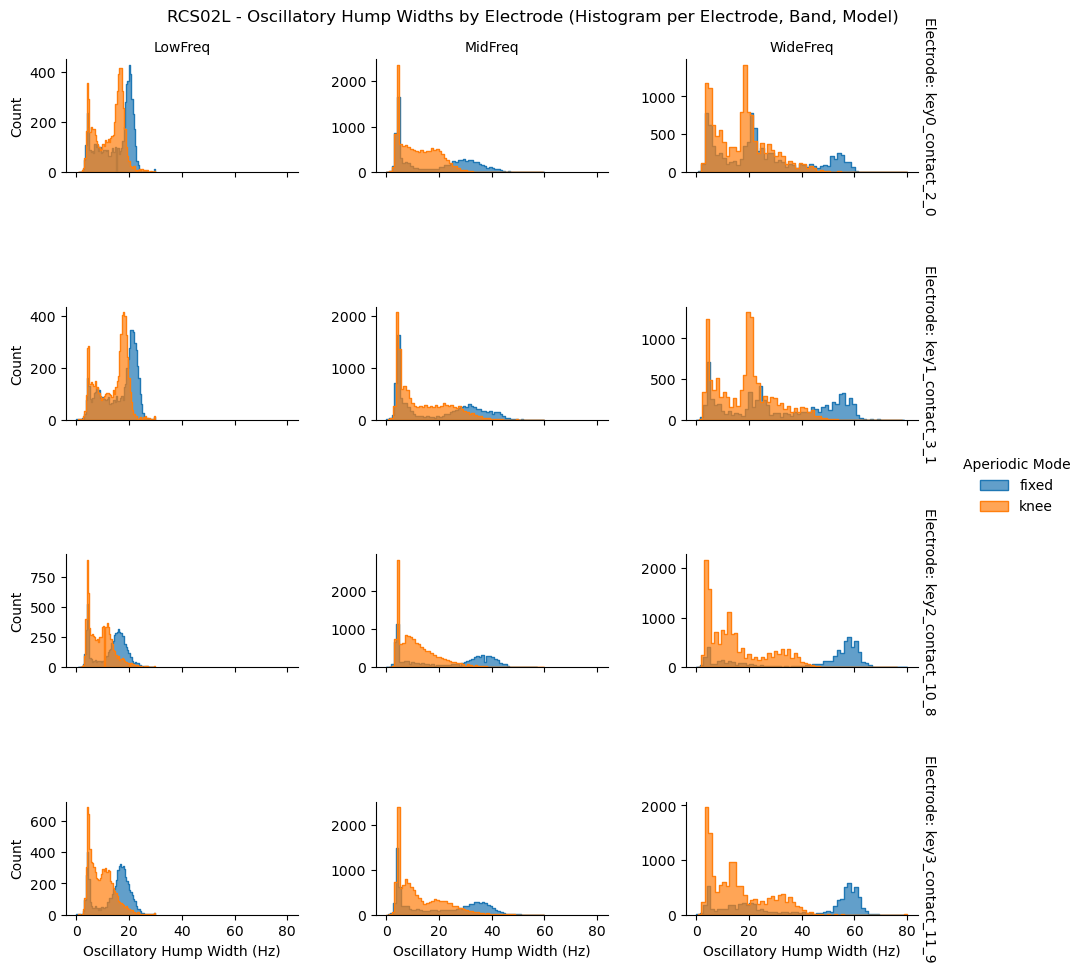

Saved histogram plot to: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_hump_width_hist_by_electrode.png

--- Cell 5a1: Hump Data Processing Complete ---


In [12]:
# -*- coding: utf-8 -*-
# --- Cell 5a1: Processing and Summarizing Hump Data ---

import pandas as pd
import os
import sys # For sys.exit
import fastparquet
print("\n--- Cell 5a1: Starting Hump Data Processing ---")

# Load Data Generated by MODIFIED Cell 4
hump_results_input_filename = os.path.join(DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_fooof_hump_results_from_cell4.csv")
summary_stats_output_filename = os.path.join(DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_hump_width_summary_stats_from_cell5a1.csv")

if not os.path.exists(hump_results_input_filename):
    print(f"Warning: Hump results file from MODIFIED Cell 4 not found: {hump_results_input_filename}. Skipping Cell 5a1.")
    df_hump_results_for_5a1 = pd.DataFrame() 
else:
    try:
        df_hump_results_for_5a1 = pd.read_csv(hump_results_input_filename)
        print(f"Successfully loaded hump results from: {hump_results_input_filename}")
    except FileNotFoundError:
        print(f"ERROR: Hump results file not found at {hump_results_input_filename}. Cannot create plots. Please run MODIFIED Cell 4.")
        sys.exit()

    if not df_hump_results_for_5a1.empty and 'hump_width' in df_hump_results_for_5a1.columns:
        print("\nSummary Statistics for Oscillatory Hump Width (Hz):")
        group_by_cols_5a1 = ['electrode_label', 'freq_band_label', 'aperiodic_mode']
        if 'electrode_label' not in df_hump_results_for_5a1.columns:
            if 'channel' in df_hump_results_for_5a1.columns:
                print("Warning: 'electrode_label' not found, grouping by 'channel' instead for hump stats.")
                group_by_cols_5a1[0] = 'channel'
            else:
                print("Warning: Neither 'electrode_label' nor 'channel' found for grouping hump stats. Skipping.")
                df_hump_results_for_5a1 = pd.DataFrame() # Make it empty

        if not df_hump_results_for_5a1.empty:
            summary_df_widths_5a1 = df_hump_results_for_5a1.dropna(subset=['hump_width'])
            if not summary_df_widths_5a1.empty:
                summary_stats_df_5a1 = summary_df_widths_5a1.groupby(
                    group_by_cols_5a1
                )['hump_width'].describe()
                print("Note: '50%' in the table below represents the Median.")
                print(summary_stats_df_5a1)
                summary_stats_df_5a1.to_csv(summary_stats_output_filename)
                print(f"\nSaved hump width summary statistics to: {summary_stats_output_filename}")
            else:
                print("No valid hump widths (non-NaN) found to generate summary statistics.")
    elif df_hump_results_for_5a1.empty:
        print("Loaded hump results DataFrame (df_hump_results_for_5a1) is empty.")
    else: # df_hump_results_for_5a1 not empty, but 'hump_width' missing
        print("Warning: 'hump_width' column missing in loaded hump results. Cannot generate summary.")

import seaborn as sns
import matplotlib.pyplot as plt

# Only plot if the summary_df_widths_5a1 DataFrame exists and is not empty
if 'summary_df_widths_5a1' in locals() and not summary_df_widths_5a1.empty:
    plot_df = summary_df_widths_5a1.copy()
    # Ensure electrode_label is str for plotting
    plot_df['electrode_label'] = plot_df['electrode_label'].astype(str)

    # Facet by electrode: one row per electrode, one col per freq band, hue = aperiodic mode
    g = sns.FacetGrid(
        plot_df,
        row="electrode_label",
        col="freq_band_label",
        hue="aperiodic_mode",
        margin_titles=True,
        sharex=True, sharey=False,
        col_order=["LowFreq", "MidFreq", "WideFreq"] if "LowFreq" in plot_df["freq_band_label"].unique() else None,
        height=2.5, aspect=1.3
    )
    g.map(sns.histplot, "hump_width", bins=60, alpha=0.7, element="step", stat="count")
    g.add_legend(title="Aperiodic Mode")
    g.set_axis_labels("Oscillatory Hump Width (Hz)", "Count")
    g.set_titles(row_template='Electrode: {row_name}', col_template='{col_name}')
    g.fig.subplots_adjust(top=0.93)
    g.fig.suptitle(f"{session_id} - Oscillatory Hump Widths by Electrode (Histogram per Electrode, Band, Model)")

    # Optional: Save figure
    hist_plot_path = os.path.join(DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_hump_width_hist_by_electrode.png")
    plt.savefig(hist_plot_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved histogram plot to: {hist_plot_path}")


print("\n--- Cell 5a1: Hump Data Processing Complete ---")
# --- End of Cell 5a1 ---

In [13]:
# -*- coding: utf-8 -*-
# --- Cell 5a2: Plots of Hump Width ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys # For sys.exit
import time # For timing
def _histplot_with_kde(data, color=None, **kwargs):
    """
    Plot histogram + KDE for hump_width column.
    Compatible with seaborn.FacetGrid.map_dataframe.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    x = data["hump_width"].dropna().to_numpy()  # Avoid pandas multi-dimensional indexing error

    if len(x) == 0:
        return  # nothing to plot

    # Plot histogram
    sns.histplot(x=x, bins=HISTOGRAM_BINS_5A2, stat="count", color=color, alpha=0.6, **kwargs)

    # Plot KDE
    sns.kdeplot(x=x, color=color, fill=True, alpha=0.3, linewidth=2, **kwargs)
print("\n--- Cell 5a2: Generating Hump Width Plots ---")
start_time_cell5a2 = time.time()

WIDTH_LIMIT_HZ_5A2 = 60.0
HISTOGRAM_BINS_5A2 = 60

hump_results_input_filename_5a2 = os.path.join(DATA_OUTPUT_PATH_NEW_CELLS, f"{session_id}_{neural_hemisphere}_fooof_hump_results_from_cell4.csv")
histogram_save_path_5a2 = os.path.join(FIGURES_OUTPUT_PATH_NEW_CELLS, 'histograms_hump_width_cell5a2') # Specific subfolder
if not os.path.exists(histogram_save_path_5a2): os.makedirs(histogram_save_path_5a2)

if not os.path.exists(hump_results_input_filename_5a2):
    print(f"Warning: Hump results file from MODIFIED Cell 4 not found: {hump_results_input_filename_5a2}. Skipping Cell 5a2.")
    df_hump_results_for_5a2 = pd.DataFrame()
else:
    try:
        df_hump_results_for_5a2 = pd.read_csv(hump_results_input_filename_5a2)
        print(f"Successfully loaded hump results from: {hump_results_input_filename_5a2}")
    except FileNotFoundError:
        print(f"ERROR: Hump results file not found at {hump_results_input_filename_5a2}. Cannot create plots.")
        sys.exit()

if not df_hump_results_for_5a2.empty and 'hump_width' in df_hump_results_for_5a2.columns:
    print(f"\nGenerating histograms with universal smoothing...")
    df_plot_5a2 = df_hump_results_for_5a2.dropna(subset=['hump_width']).copy()
    df_plot_5a2 = df_plot_5a2[df_plot_5a2['hump_width'] <= WIDTH_LIMIT_HZ_5A2]

    hue_col_5a2 = None
    if 'electrode_label' in df_plot_5a2.columns:
        hue_col_5a2 = 'electrode_label'
    elif 'channel' in df_plot_5a2.columns:
        hue_col_5a2 = 'channel'
    else:
        print("Warning: Neither 'electrode_label' nor 'channel' found for hue in hump width plots. Plots may be incorrect.")

    if not df_plot_5a2.empty and hue_col_5a2:
        


        g = sns.FacetGrid(
            df_plot_5a2,
            col="freq_band_label", row="aperiodic_mode", 
            hue=hue_col_5a2,
            margin_titles=True, height=4, aspect=1.2, 
            sharey=False, legend_out=True
        )
        g.map_dataframe(_histplot_with_kde)


        g.set_axis_labels("Oscillatory Hump Width (Hz)", "Count")
        g.set_titles(col_template="{col_name}", row_template="{row_name}")
        g.set(xlim=(0, WIDTH_LIMIT_HZ_5A2))
        g.add_legend(title=hue_col_5a2.replace('_', ' ').title()) # Make legend title nicer
        g.fig.suptitle(f'{session_id} - Distribution of Oscillatory Hump Widths (Humps from Cell 4)', y=1.03)
        g.tight_layout(rect=[0, 0, 1, 0.97])
        
        plot_filename_final_5a2 = os.path.join(histogram_save_path_5a2, f"{session_id}_smoothed_hump_width_histogram_cell5a2.png")
        g.savefig(plot_filename_final_5a2, dpi=300) # Save with 300 dpi for better quality
        plt.close(g.fig)
        print(f"Presentation-ready histogram saved to: {plot_filename_final_5a2}")
    elif not hue_col_5a2:
        print("Skipping hump width plot generation as no suitable hue column was found.")
    else: # df_plot_5a2 is empty
        print("No data left to plot for hump widths after filtering.")
elif df_hump_results_for_5a2.empty:
    print("Loaded hump results DataFrame (df_hump_results_for_5a2) is empty.")
else:
    print("Warning: 'hump_width' column missing in loaded hump results. Cannot create histograms.")

end_time_cell5a2 = time.time()
print(f"\nCell 5a2 execution time: {end_time_cell5a2 - start_time_cell5a2:.2f} seconds.")
print("--- Cell 5a2: Hump Width Plotting Complete ---")
# --- End of Cell 5a2 ---


--- Cell 5a2: Generating Hump Width Plots ---
Successfully loaded hump results from: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_fooof_hump_results_from_cell4.csv

Generating histograms with universal smoothing...
Presentation-ready histogram saved to: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_figures/histograms_hump_width_cell5a2/RCS02L_smoothed_hump_width_histogram_cell5a2.png

Cell 5a2 execution time: 6.50 seconds.
--- Cell 5a2: Hump Width Plotting Complete ---


In [14]:
# -*- coding: utf-8 -*-
# --- Cell 5b: Visualizing Average PSDs by Clinical State ---
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import warnings
from tqdm.notebook import tqdm

NEW_CLINICAL_STATE_COLORS = {
    'Dyskinetic Mobile': '#d62728',        # red
    'Immobile': '#1f77b4',                 # blue
    'Non-Dyskinetic Mobile': '#2ca02c',    # green
    'Transitional Mobile': '#ff7f0e',      # orange
    'Unknown': '#808080'                   # gray fallback
}

# >>> Minimum number of segments to include a line in the plot
MIN_SEGMENTS_FOR_PLOT = 100

print("\n--- Cell 5b: Starting Average PSD Visualization by Clinical State ---")

# --- Load raw PSDs collected in Cell 4 ---
raw_psds_input_filename_c5b = os.path.join(
    DATA_OUTPUT_PATH_NEW_CELLS,
    f"{session_id}_{neural_hemisphere}_raw_psds_for_averaging_from_cell4.parquet"
)
if not os.path.exists(raw_psds_input_filename_c5b):
    print(f"ERROR: Raw PSDs file from Cell 4 not found: {raw_psds_input_filename_c5b}. Skipping Cell 5b.")
    df_all_raw_psds_for_c5b = pd.DataFrame() # Create empty to allow script to run
else:
    try:
        df_all_raw_psds_for_c5b = pd.read_parquet(raw_psds_input_filename_c5b, engine='fastparquet')
        print(f"Successfully loaded raw PSDs from: {raw_psds_input_filename_c5b}. Shape: {df_all_raw_psds_for_c5b.shape}")
        if 'psd' not in df_all_raw_psds_for_c5b.columns or 'freqs' not in df_all_raw_psds_for_c5b.columns:
             print("ERROR: 'psd' or 'freqs' column missing in loaded raw PSDs. Cannot proceed with Cell 5b.")
             df_all_raw_psds_for_c5b = pd.DataFrame()
    except Exception as e:
        print(f"ERROR loading raw PSDs parquet for Cell 5b: {e}")
        df_all_raw_psds_for_c5b = pd.DataFrame()

if df_all_raw_psds_for_c5b.empty:
    print("No raw PSD data available for Cell 5b. Skipping averaging and plotting.")
elif 'fooof_input_df' not in locals() or fooof_input_df.empty:
    print("ERROR: fooof_input_df (for clinical states) not available in Cell 5b. Skipping.")
else:
    # --- Merge raw PSDs with Clinical State Information ---
    print("Merging raw PSDs with clinical state information...")
    clinical_cols_to_merge = ['Aligned_PKG_UnixTimestamp', 'Channel',
                              'Clinical_State_2min_Window', 'Clinical_State_Aggregated']
    if not all(col in fooof_input_df.columns for col in clinical_cols_to_merge):
        print(f"ERROR: One or more clinical columns missing from fooof_input_df: {clinical_cols_to_merge}. Skipping merge.")
        df_merged_psds_for_avg = pd.DataFrame()
    else:
        df_clinical_states_c5b = fooof_input_df[clinical_cols_to_merge].drop_duplicates()

        # --- Align column names and types ---
        df_all_raw_psds_for_c5b = df_all_raw_psds_for_c5b.rename(columns={
            'channel': 'Channel',
            'timestamp_unix': 'Aligned_PKG_UnixTimestamp'
        })
        df_all_raw_psds_for_c5b['Aligned_PKG_UnixTimestamp'] = df_all_raw_psds_for_c5b['Aligned_PKG_UnixTimestamp'].astype('int64')
        df_clinical_states_c5b['Aligned_PKG_UnixTimestamp'] = df_clinical_states_c5b['Aligned_PKG_UnixTimestamp'].astype('int64')

        # --- Merge using nearest timestamp match within 30s tolerance ---
        df_all_raw_psds_for_c5b_sorted = df_all_raw_psds_for_c5b.sort_values('Aligned_PKG_UnixTimestamp')
        df_clinical_states_c5b_sorted = df_clinical_states_c5b.sort_values('Aligned_PKG_UnixTimestamp')
        df_merged_psds_for_avg = pd.merge_asof(
            df_all_raw_psds_for_c5b_sorted,
            df_clinical_states_c5b_sorted,
            on='Aligned_PKG_UnixTimestamp',
            by='Channel',
            direction='nearest',
            tolerance=30000  # in milliseconds
        )

        # --- Fill any unmatched labels with 'Unknown' ---
        df_merged_psds_for_avg['Clinical_State_2min_Window'] = df_merged_psds_for_avg['Clinical_State_2min_Window'].fillna('Unknown')

        if 'electrode_label' not in df_merged_psds_for_avg.columns and electrode_labels:
            df_merged_psds_for_avg['electrode_label'] = df_merged_psds_for_avg['Channel'].map(electrode_labels)

        if df_merged_psds_for_avg.empty:
            print("No data after merging PSDs with clinical states.")
        else:
            print(f"Successfully merged. Shape of merged data for averaging: {df_merged_psds_for_avg.shape}")
            df_merged_psds_for_avg['Clinical_State_2min_Window'] = df_merged_psds_for_avg['Clinical_State_2min_Window'].fillna('Unknown')

    if not df_merged_psds_for_avg.empty:
        # --- Calculate Average PSDs ---
        print("Calculating average PSDs per channel and clinical state...")
        example_freqs_c5b = df_merged_psds_for_avg['freqs'].iloc[0]
        if isinstance(example_freqs_c5b, str):
            try:
                example_freqs_c5b = np.array(json.loads(example_freqs_c5b))
            except Exception as e:
                print(f"ERROR parsing frequency vector: {e}")
                example_freqs_c5b = np.array([])

        def average_psds(psd_list):
            psd_arrays = []
            for item in psd_list:
                if isinstance(item, np.ndarray):
                    psd_arrays.append(item)
                elif isinstance(item, str):
                    try:
                        psd_arrays.append(np.array(json.loads(item)))
                    except Exception as e:
                        print(f"Error parsing PSD string: {e}")
            if not psd_arrays:
                return None, 0
            return np.mean(np.array(psd_arrays), axis=0), len(psd_arrays)

        grouping_cols_c5b = ['Channel', 'electrode_label', 'Clinical_State_2min_Window']
        if 'electrode_label' not in df_merged_psds_for_avg.columns:
            print("Warning: 'electrode_label' not found for grouping in Cell 5b. Using 'Channel'.")
            grouping_cols_c5b = ['Channel', 'Clinical_State_2min_Window']
            df_merged_psds_for_avg['electrode_label'] = df_merged_psds_for_avg['Channel']  # temp for loop

        averaged_psd_results_c5b = []
        for name, group in tqdm(df_merged_psds_for_avg.groupby(grouping_cols_c5b, observed=True), desc="Averaging PSDs"):
            channel_key, el_label, clinical_state = name[0], name[1], name[2]
            avg_psd_linear, n_segments = average_psds(group['psd'].tolist())
            if avg_psd_linear is not None:
                averaged_psd_results_c5b.append({
                    'Channel': channel_key,
                    'ElectrodeLabel': el_label if el_label else channel_key,
                    'Clinical_State': clinical_state,
                    'Average_PSD_Linear': avg_psd_linear,
                    'Frequencies': example_freqs_c5b,
                    'Num_Segments_Averaged': n_segments
                })

        df_averaged_psds_c5b = pd.DataFrame(averaged_psd_results_c5b)

        if df_averaged_psds_c5b.empty:
            print("No averaged PSDs were generated.")
        else:
            print(f"Generated {len(df_averaged_psds_c5b)} averaged PSDs.")

            # --- Plot Average PSDs ---
            output_folder_c5b_avg_psd_plots = os.path.join(FIGURES_OUTPUT_PATH_NEW_CELLS, 'average_psds_by_state_cell5b')
            os.makedirs(output_folder_c5b_avg_psd_plots, exist_ok=True)
            print(f"Average PSD plots will be saved in: {output_folder_c5b_avg_psd_plots}")

            unique_channels_to_plot_c5b = df_averaged_psds_c5b['Channel'].unique()
            for ch_key in unique_channels_to_plot_c5b:
                df_channel_all = df_averaged_psds_c5b[df_averaged_psds_c5b['Channel'] == ch_key]

                # >>> Only plot states with enough segments
                df_channel = df_channel_all[df_channel_all['Num_Segments_Averaged'] >= MIN_SEGMENTS_FOR_PLOT].copy()

                if df_channel.empty:
                    print(f"Skipping Channel {ch_key}: no states with N >= {MIN_SEGMENTS_FOR_PLOT}.")
                    continue

                el_label_for_plot = df_channel['ElectrodeLabel'].iloc[0]
                plt.figure(figsize=(12, 7))

                # Track if we actually plotted anything
                any_plotted = False
                for _, row_avg in df_channel.iterrows():
                    state = row_avg['Clinical_State']
                    freqs = row_avg['Frequencies']
                    avg_psd_log = np.log10(row_avg['Average_PSD_Linear'])
                    n_seg = row_avg['Num_Segments_Averaged']

                    color = NEW_CLINICAL_STATE_COLORS.get(state, '#808080')
                    plt.plot(freqs, avg_psd_log, label=f"{state} (N={n_seg})", color=color, linewidth=2)
                    any_plotted = True

                if not any_plotted:
                    print(f"Channel {ch_key}: nothing plotted after thresholding (N >= {MIN_SEGMENTS_FOR_PLOT}).")
                    plt.close()
                    continue

                plt.title(f"Average PSD by Clinical State - {session_id} - Channel {el_label_for_plot}")
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Log10 Power Spectral Density")
                plt.xlim(0, 100)
                plt.legend(title=f"Clinical State (N ≥ {MIN_SEGMENTS_FOR_PLOT})")
                plt.grid(True, which="both", ls="--", alpha=0.5)
                plt.tight_layout()

                plot_filename = os.path.join(
                    output_folder_c5b_avg_psd_plots,
                    f"{session_id}_{el_label_for_plot}_avg_psd_by_state.png"
                )
                plt.savefig(plot_filename)
                plt.close()

            print("Finished plotting average PSDs by clinical state.")

# Hand-off to Cell 5c
if 'df_averaged_psds_c5b' in locals() and not df_averaged_psds_c5b.empty:
    print("Cell 5b: Average PSDs DataFrame is available for Cell 5c.")
else:
    print("Cell 5b: Average PSDs DataFrame is NOT available for Cell 5c.")
    df_averaged_psds_c5b = pd.DataFrame()  # Ensure it's defined for 5c check

print("\n--- Cell 5b: Average PSD Visualization Complete ---")



--- Cell 5b: Starting Average PSD Visualization by Clinical State ---
Successfully loaded raw PSDs from: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_raw_psds_for_averaging_from_cell4.parquet. Shape: (18696, 6)
Merging raw PSDs with clinical state information...
Successfully merged. Shape of merged data for averaging: (18696, 8)
Calculating average PSDs per channel and clinical state...


Averaging PSDs:   0%|          | 0/20 [00:00<?, ?it/s]

Generated 20 averaged PSDs.
Average PSD plots will be saved in: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_figures/average_psds_by_state_cell5b
Finished plotting average PSDs by clinical state.
Cell 5b: Average PSDs DataFrame is available for Cell 5c.

--- Cell 5b: Average PSD Visualization Complete ---


In [ ]:
print("Raw PSDs columns:", df_all_raw_psds_for_c5b.columns.tolist())
print("Clinical states columns:", df_clinical_states_c5b.columns.tolist())

In [15]:
# -*- coding: utf-8 -*-
# --- Cell 5c: Run FOOOF on Averaged PSDs and Plot (with N>=100 gating & dual legends) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from fooof import FOOOF
from tqdm.notebook import tqdm  # make sure tqdm is available

MIN_SEGMENTS_FOR_PLOT = 100  # keep in sync with 5b

print("\n--- Cell 5c: Starting FOOOF on Averaged PSDs ---")

if 'df_averaged_psds_c5b' not in locals() or df_averaged_psds_c5b.empty:
    print("ERROR: Averaged PSDs DataFrame (df_averaged_psds_c5b) not available from Cell 5b. Skipping Cell 5c.")
else:
    print(f"Processing {len(df_averaged_psds_c5b)} averaged PSDs for FOOOF fitting "
          f"(will skip rows with N < {MIN_SEGMENTS_FOR_PLOT}).")

    # Output folder
    output_folder_c5c_fooof_avg_plots = os.path.join(
        FIGURES_OUTPUT_PATH_NEW_CELLS, 'fooof_on_average_psds_cell5c'
    )
    os.makedirs(output_folder_c5c_fooof_avg_plots, exist_ok=True)
    print(f"FOOOF plots on averaged PSDs will be saved in: {output_folder_c5c_fooof_avg_plots}")

    # Fit range
    default_fit_range_label_c5c = 'WideFreq'
    if default_fit_range_label_c5c in ITERATIVE_FREQ_BANDS:
        current_freq_range_c5c = ITERATIVE_FREQ_BANDS[default_fit_range_label_c5c]
    else:
        current_freq_range_c5c = list(ITERATIVE_FREQ_BANDS.values())[0] if ITERATIVE_FREQ_BANDS else [10, 90]
        default_fit_range_label_c5c = list(ITERATIVE_FREQ_BANDS.keys())[0] if ITERATIVE_FREQ_BANDS else f"{current_freq_range_c5c[0]}-{current_freq_range_c5c[1]}Hz"
        print(f"Warning: '{default_fit_range_label_c5c}' not found in ITERATIVE_FREQ_BANDS. Using: {current_freq_range_c5c}")

    fooofed_average_results_c5c = []

    for _, row_avg_psd in tqdm(df_averaged_psds_c5b.iterrows(),
                               total=len(df_averaged_psds_c5b),
                               desc="FOOOFing Avg PSDs"):

        # ---- EARLY GATE: skip low-N before making any figure ----
        if row_avg_psd['Num_Segments_Averaged'] < MIN_SEGMENTS_FOR_PLOT:
            continue

        channel_key = row_avg_psd['Channel']
        el_label = row_avg_psd['ElectrodeLabel']
        clinical_state = row_avg_psd['Clinical_State']
        avg_psd_linear = row_avg_psd['Average_PSD_Linear']
        freqs = row_avg_psd['Frequencies']
        n_segments = row_avg_psd['Num_Segments_Averaged']

        # Basic sanity
        if avg_psd_linear is None or freqs is None:
            continue
        if isinstance(avg_psd_linear, str):
            try: avg_psd_linear = np.array(json.loads(avg_psd_linear))
            except Exception: continue
        if isinstance(freqs, str):
            try: freqs = np.array(json.loads(freqs))
            except Exception: continue
        if len(avg_psd_linear) == 0 or len(freqs) == 0 or len(avg_psd_linear) != len(freqs):
            continue

        # ---- Create figure only for rows we will actually process ----
        fig_avg, axes_avg = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1]})
        fig_avg.suptitle(
            f"FOOOF on Averaged PSD: {session_id} - Ch {el_label} - State: {clinical_state} (N={n_segments})\n"
            f"Fit Range: {default_fit_range_label_c5c} ({current_freq_range_c5c[0]}-{current_freq_range_c5c[1]} Hz)",
            fontsize=12
        )

        models_fitted_this_spectrum = 0

        # ---------- FIXED ----------
        fm_fixed_avg = FOOOF(**basic_fooof_settings)
        try:
            fm_fixed_avg.fit(freqs, avg_psd_linear, freq_range=current_freq_range_c5c)
            if fm_fixed_avg.has_model:
                # Disable FOOOF's built-in legend, then add our two legends
                fm_fixed_avg.plot(ax=axes_avg[0], plt_log=True, add_legend=False)

                # Spectrum legend (bottom-left)
                handles_spec = [
                    plt.Line2D([0], [0], color='black', label='Original Spectrum'),
                    plt.Line2D([0], [0], color='red', label='Full Model Fit'),
                    plt.Line2D([0], [0], color='blue', linestyle='--', label='Aperiodic Fit'),
                ]
                leg1 = axes_avg[0].legend(handles=handles_spec, loc='lower left', fontsize=8, frameon=True)
                axes_avg[0].add_artist(leg1)

                # Metrics legend (top-right)
                metrics_text_fixed = f"Model: Fixed\nR² = {fm_fixed_avg.r_squared_:.3f}\nErr = {fm_fixed_avg.error_:.2e}"
                leg2 = axes_avg[0].legend([metrics_text_fixed], loc='upper right', fontsize=8, frameon=True, handlelength=0)
                for h in leg2.legendHandles: h.set_visible(False)  # text-only legend
                axes_avg[0].add_artist(leg2)

                axes_avg[0].set_title("Aperiodic Mode: Fixed")
                axes_avg[0].grid(True, which="both", ls="--", alpha=0.5)

                fooofed_average_results_c5c.append({
                    'Channel': channel_key, 'ElectrodeLabel': el_label, 'Clinical_State': clinical_state,
                    'AperiodicMode': 'fixed', 'R2': fm_fixed_avg.r_squared_, 'Error': fm_fixed_avg.error_,
                    'Offset': fm_fixed_avg.aperiodic_params_[0], 'Exponent': fm_fixed_avg.aperiodic_params_[1],
                    'NumPeaks': len(fm_fixed_avg.peak_params_)
                })
                models_fitted_this_spectrum += 1
        except Exception as e_fit_fixed:
            print(f"  Warning: FOOOF 'fixed' fit failed for avg PSD Ch {el_label}, State {clinical_state}. Error: {e_fit_fixed}")
            axes_avg[0].set_title("Aperiodic Mode: Fixed (No Fit)")

        # ---------- KNEE ----------
        fm_knee_avg = FOOOF(**knee_fooof_settings)
        try:
            fm_knee_avg.fit(freqs, avg_psd_linear, freq_range=current_freq_range_c5c)
            if fm_knee_avg.has_model:
                fm_knee_avg.plot(ax=axes_avg[1], plt_log=True, add_legend=False)

                # Spectrum legend (bottom-left)
                handles_spec = [
                    plt.Line2D([0], [0], color='black', label='Original Spectrum'),
                    plt.Line2D([0], [0], color='red', label='Full Model Fit'),
                    plt.Line2D([0], [0], color='blue', linestyle='--', label='Aperiodic Fit'),
                ]
                leg1 = axes_avg[1].legend(handles=handles_spec, loc='lower left', fontsize=8, frameon=True)
                axes_avg[1].add_artist(leg1)

                # Metrics legend (top-right)
                metrics_text_knee = f"Model: Knee\nR² = {fm_knee_avg.r_squared_:.3f}\nErr = {fm_knee_avg.error_:.2e}"
                leg2 = axes_avg[1].legend([metrics_text_knee], loc='upper right', fontsize=8, frameon=True, handlelength=0)
                for h in leg2.legendHandles: h.set_visible(False)
                axes_avg[1].add_artist(leg2)

                axes_avg[1].set_title("Aperiodic Mode: Knee")
                axes_avg[1].grid(True, which="both", ls="--", alpha=0.5)

                fooofed_average_results_c5c.append({
                    'Channel': channel_key, 'ElectrodeLabel': el_label, 'Clinical_State': clinical_state,
                    'AperiodicMode': 'knee', 'R2': fm_knee_avg.r_squared_, 'Error': fm_knee_avg.error_,
                    'Offset': fm_knee_avg.aperiodic_params_[0], 'Knee': fm_knee_avg.aperiodic_params_[1],
                    'Exponent': fm_knee_avg.aperiodic_params_[2],
                    'NumPeaks': len(fm_knee_avg.peak_params_)
                })
                models_fitted_this_spectrum += 1
        except Exception as e_fit_knee:
            print(f"  Warning: FOOOF 'knee' fit failed for avg PSD Ch {el_label}, State {clinical_state}. Error: {e_fit_knee}")
            axes_avg[1].set_title("Aperiodic Mode: Knee (No Fit)")

        # ---- Save only if at least one model fit ----
        if models_fitted_this_spectrum > 0:
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plot_filename_avg_fooof = os.path.join(
                output_folder_c5c_fooof_avg_plots,
                f"{session_id}_{el_label}_{clinical_state.replace(' ', '_')}_avg_psd_fooof.png"
            )
            fig_avg.savefig(plot_filename_avg_fooof)
        plt.close(fig_avg)

    # ---- Save results table ----
    df_fooofed_average_results_c5c = pd.DataFrame(fooofed_average_results_c5c)
    if not df_fooofed_average_results_c5c.empty:
        print(f"\nGenerated {len(df_fooofed_average_results_c5c)} FOOOF model fits for averaged PSDs.")
        avg_fooof_results_filename = os.path.join(
            DATA_OUTPUT_PATH_NEW_CELLS,
            f"{session_id}_{neural_hemisphere}_fooof_fits_on_average_psds_from_cell5c.csv"
        )
        df_fooofed_average_results_c5c.to_csv(avg_fooof_results_filename, index=False)
        print(f"Saved FOOOF results on averaged PSDs to: {avg_fooof_results_filename}")
    else:
        print("\nNo FOOOF models were successfully fitted to the averaged PSDs.")

print("\n--- Cell 5c: FOOOF on Averaged PSDs Complete ---")



--- Cell 5c: Starting FOOOF on Averaged PSDs ---
Processing 20 averaged PSDs for FOOOF fitting (will skip rows with N < 100).
FOOOF plots on averaged PSDs will be saved in: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_figures/fooof_on_average_psds_cell5c


FOOOFing Avg PSDs:   0%|          | 0/20 [00:00<?, ?it/s]


Generated 40 FOOOF model fits for averaged PSDs.
Saved FOOOF results on averaged PSDs to: /home/jackson/step3_fooof_results_neural_pkg_aligned/RCS02L/Left/new_analysis_data/RCS02L_Left_fooof_fits_on_average_psds_from_cell5c.csv

--- Cell 5c: FOOOF on Averaged PSDs Complete ---


In [16]:
# -*- coding: utf-8 -*-
# --- Cell 8: Generate and Save Master DataFrame ---
# This cell now combines:
# 1. Aperiodic parameters (fixed, knee, best) from df_fine_grain_results_cell4
# 2. Original segment info, Total_Daily_LEDD_mg, Beta_Peak_Power, Gamma_Peak_Power from fooof_input_df

import pandas as pd # Ensure pandas is imported for pd.isna
import numpy as np  # Ensure numpy is imported for np.nan
import sys          # For sys.exit

print("\n--- Cell 8: Starting Master DataFrame Generation (with new metrics) ---")

# Prerequisite DataFrames:
# - fooof_input_df (from Cell 3, now with LEDD, Beta_Peak_Power, Gamma_Peak_Power)
# - df_fine_grain_results_cell4 (from MODIFIED Cell 4, with detailed aperiodic fits)

if 'fooof_input_df' not in locals() or fooof_input_df.empty:
    print("CRITICAL WARNING in Cell 8: fooof_input_df is not available or empty. Creating a dummy DataFrame for LEDD prompt testing.")
    fooof_input_df = pd.DataFrame({'Total_Daily_LEDD_mg': [np.nan, np.nan, np.nan]}) # Dummy for testing
    # sys.exit("ERROR in Cell 8: fooof_input_df is not available or empty. Cannot create master table.")

if 'df_fine_grain_results_cell4' not in locals() or ('df_fine_grain_results_cell4' in locals() and df_fine_grain_results_cell4.empty):
    print("Warning in Cell 8: df_fine_grain_results_cell4 not available or empty. Master table may lack detailed FOOOF results.")
    # Create an empty df with expected columns to allow merge to proceed but result in NaNs for FOOOF columns
    df_fine_grain_results_cell4 = pd.DataFrame(columns=['timestamp_unix', 'channel', 'electrode_label', 'freq_band_label', 'aperiodic_mode',
                                                        'r_squared', 'fit_error', 'aperiodic_offset', 'aperiodic_knee', 
                                                        'aperiodic_exponent', 'num_model_peaks'])


trigger_ledd_input_prompt = False
if 'fooof_input_df' in locals() and ('Total_Daily_LEDD_mg' not in fooof_input_df.columns):
    print("Warning: 'Total_Daily_LEDD_mg' column missing from fooof_input_df. Cannot prompt for LEDD override.")
    fooof_input_df['Total_Daily_LEDD_mg'] = np.nan # Add the column as NaNs

if trigger_ledd_input_prompt:
    while True:
        try:
            user_ledd_value_str = input("Please enter a default LEDD value to propagate for the entire 'Total_Daily_LEDD_mg' column (e.g., 0 or 500), or type 'skip' to leave as is: ")
            if user_ledd_value_str.lower() == 'skip':
                print("Skipping LEDD override. 'Total_Daily_LEDD_mg' will remain as is (likely NaNs).")
                break
            user_ledd_value = float(user_ledd_value_str)
            fooof_input_df['Total_Daily_LEDD_mg'] = user_ledd_value
            print(f"'Total_Daily_LEDD_mg' column has been filled with {user_ledd_value}.")
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value for LEDD or 'skip'.")

expected_pivot_values = ['r_squared', 'fit_error', 'aperiodic_offset', 'aperiodic_knee', 'aperiodic_exponent', 'num_model_peaks']
actual_pivot_values = [val for val in expected_pivot_values if val in df_fine_grain_results_cell4.columns]

if not actual_pivot_values:
    print("Warning: No value columns found in df_fine_grain_results_cell4 for pivoting. FOOOF params will be empty.")
    df_pivot_foof_params = pd.DataFrame(columns=['Aligned_PKG_UnixTimestamp', 'Channel', 'electrode_label', 'FreqRangeLabel']) # Create empty with index cols
    # Add placeholder columns that would have been created by pivot, filled with NaN
    pivoted_cols_to_add = []
    for mode in ['fixed', 'knee']:
        for val_col in expected_pivot_values:
            pivoted_cols_to_add.append(f'{val_col}_{mode}')
    for col in pivoted_cols_to_add:
        df_pivot_foof_params[col] = np.nan

else:
    df_pivot_foof_params = df_fine_grain_results_cell4.pivot_table(
        index=['timestamp_unix', 'channel', 'electrode_label', 'freq_band_label'], 
        columns='aperiodic_mode',
        values=actual_pivot_values,
        aggfunc='first' 
    ).reset_index()
    df_pivot_foof_params.columns = [f'{col[0]}_{col[1]}'.rstrip('_') if col[1] else col[0] for col in df_pivot_foof_params.columns]


rename_dict_cell8 = { 
    'r_squared_fixed': 'R2_Fixed', 'fit_error_fixed': 'Error_Fixed',
    'aperiodic_offset_fixed': 'Offset_Fixed', 'aperiodic_exponent_fixed': 'Exponent_Fixed',
    'num_model_peaks_fixed': 'Num_Peaks_Fixed',
    'r_squared_knee': 'R2_Knee', 'fit_error_knee': 'Error_Knee',
    'aperiodic_offset_knee': 'Offset_Knee', 'aperiodic_knee_knee': 'Knee_Knee',
    'aperiodic_exponent_knee': 'Exponent_Knee',
    'num_model_peaks_knee': 'Num_Peaks_Knee',
    'channel': 'Channel', 'freq_band_label': 'FreqRangeLabel',
    'timestamp_unix': 'Aligned_PKG_UnixTimestamp' 
}
df_pivot_foof_params.rename(columns=rename_dict_cell8, inplace=True)

# --- 2. Determine the "Best Model" from pivoted FOOOF params ---
print("Determining best aperiodic model based on R-squared...")
best_model_param_cols = ['BestModel_AperiodicMode', 'Offset_BestModel', 'Exponent_BestModel', 
                         'Knee_BestModel', 'R2_BestModel', 'Error_BestModel', 'Num_Peaks_BestModel']

if 'R2_Fixed' in df_pivot_foof_params.columns and 'R2_Knee' in df_pivot_foof_params.columns:
    r2_fixed_fillna = df_pivot_foof_params['R2_Fixed'].fillna(-np.inf)
    r2_knee_fillna = df_pivot_foof_params['R2_Knee'].fillna(-np.inf)
    
    conditions_best_model = [ r2_knee_fillna > r2_fixed_fillna, r2_fixed_fillna >= r2_knee_fillna ]
    choices_mode_best = ['knee', 'fixed']
    df_pivot_foof_params['BestModel_AperiodicMode'] = np.select(conditions_best_model, choices_mode_best, default='n/a')

    for mode in ['Fixed', 'Knee']:
        for param in ['Offset', 'Exponent', 'Knee', 'R2', 'Error', 'Num_Peaks']:
            col_name = f"{param}_{mode}"
            if col_name not in df_pivot_foof_params:
                df_pivot_foof_params[col_name] = np.nan
    
    df_pivot_foof_params['Offset_BestModel'] = np.where(df_pivot_foof_params['BestModel_AperiodicMode'] == 'knee', df_pivot_foof_params['Offset_Knee'], df_pivot_foof_params['Offset_Fixed'])
    df_pivot_foof_params['Exponent_BestModel'] = np.where(df_pivot_foof_params['BestModel_AperiodicMode'] == 'knee', df_pivot_foof_params['Exponent_Knee'], df_pivot_foof_params['Exponent_Fixed'])
    df_pivot_foof_params['Knee_BestModel'] = np.where(df_pivot_foof_params['BestModel_AperiodicMode'] == 'knee', df_pivot_foof_params['Knee_Knee'], np.nan)
    df_pivot_foof_params['R2_BestModel'] = np.where(df_pivot_foof_params['BestModel_AperiodicMode'] == 'knee', df_pivot_foof_params['R2_Knee'], df_pivot_foof_params['R2_Fixed'])
    df_pivot_foof_params['Error_BestModel'] = np.where(df_pivot_foof_params['BestModel_AperiodicMode'] == 'knee', df_pivot_foof_params['Error_Knee'], df_pivot_foof_params['Error_Fixed'])
    df_pivot_foof_params['Num_Peaks_BestModel'] = np.where(df_pivot_foof_params['BestModel_AperiodicMode'] == 'knee', df_pivot_foof_params['Num_Peaks_Knee'], df_pivot_foof_params['Num_Peaks_Fixed'])
else: 
    print("Warning: R2_Fixed or R2_Knee not found in pivoted FOOOF data. Best model columns will be NaN.")
    for col in best_model_param_cols:
        df_pivot_foof_params[col] = np.nan
df_pivot_foof_params['ErrorMsg_FOOOF'] = '' 

# --- 3. Merge FOOOF results with original segment info from fooof_input_df ---
print("Merging pivoted FOOOF results with main segment data (including LEDD, Beta, Gamma)...")
segment_base_cols = [
    'Aligned_PKG_UnixTimestamp', 'Channel', 'ElectrodeLabel',
    'SessionID', 'Hemisphere', 
    'Neural_Segment_Start_Unixtime', 'Neural_Segment_End_Unixtime',
    'Neural_Segment_Duration_Sec', 'FS', 'PSD_Data_Str', 'Frequency_Vector_Str',
    'Aligned_PKG_DateTime_Str', 'Clinical_State_2min_Window', 'Clinical_State_Aggregated',
    'Aligned_BK', 'Aligned_DK', 'Aligned_Tremor_Score', 'Aligned_Tremor',
    'Total_Daily_LEDD_mg',
    'Beta_Peak_Power_at_DominantFreq',
    'Gamma_Peak_Power_at_DominantFreq'
]
segment_base_cols_present = [col for col in segment_base_cols if col in fooof_input_df.columns]
df_segment_info_to_merge = fooof_input_df[segment_base_cols_present].drop_duplicates(subset=['Aligned_PKG_UnixTimestamp', 'Channel'])

# Ensure merge keys exist and are of correct type in both dataframes
if 'Aligned_PKG_UnixTimestamp' not in df_pivot_foof_params.columns:
    df_pivot_foof_params['Aligned_PKG_UnixTimestamp'] = np.nan # Add if missing
if 'Channel' not in df_pivot_foof_params.columns:
    df_pivot_foof_params['Channel'] = np.nan

df_pivot_foof_params['Aligned_PKG_UnixTimestamp'] = pd.to_numeric(df_pivot_foof_params['Aligned_PKG_UnixTimestamp'], errors='coerce').astype('Int64')
df_segment_info_to_merge['Aligned_PKG_UnixTimestamp'] = pd.to_numeric(df_segment_info_to_merge['Aligned_PKG_UnixTimestamp'], errors='coerce').astype('Int64')
df_pivot_foof_params['Channel'] = df_pivot_foof_params['Channel'].astype(str)
df_segment_info_to_merge['Channel'] = df_segment_info_to_merge['Channel'].astype(str)


master_df_final = pd.merge(
    df_pivot_foof_params,
    df_segment_info_to_merge,
    on=['Aligned_PKG_UnixTimestamp', 'Channel'],
    how='left' 
)

if 'ITERATIVE_FREQ_BANDS' in locals() and isinstance(ITERATIVE_FREQ_BANDS, dict):
    band_map_low = {k: v[0] for k, v in ITERATIVE_FREQ_BANDS.items()} 
    band_map_high = {k: v[1] for k, v in ITERATIVE_FREQ_BANDS.items()}
    if 'FreqRangeLabel' in master_df_final.columns:
        master_df_final['FreqLow'] = master_df_final['FreqRangeLabel'].map(band_map_low)
        master_df_final['FreqHigh'] = master_df_final['FreqRangeLabel'].map(band_map_high)
    else:
        master_df_final['FreqLow'], master_df_final['FreqHigh'] = np.nan, np.nan
else:
    print("Warning: ITERATIVE_FREQ_BANDS not defined or not a dict, FreqLow/High cannot be mapped.")
    master_df_final['FreqLow'], master_df_final['FreqHigh'] = np.nan, np.nan


# --- 4. Finalize and Save Master Table ---
final_columns_ordered = [col for col in master_table_columns if col in master_df_final.columns]
# Add any columns that might be in master_df_final but not in master_table_columns (e.g. if new ones were missed)
# or if some columns from master_table_columns were not generated
existing_cols_in_master_df = set(master_df_final.columns)
final_ordered_and_existing_cols = []
for col in master_table_columns:
    if col in existing_cols_in_master_df:
        final_ordered_and_existing_cols.append(col)
    else:
        print(f"Info: Column '{col}' from master_table_columns definition is not in the generated master_df_final. It will be missing.")

# Ensure all columns from master_df_final are included, even if not in master_table_columns initially
for col in master_df_final.columns:
    if col not in final_ordered_and_existing_cols:
        final_ordered_and_existing_cols.append(col) # Add to end

master_df_to_save = master_df_final[final_ordered_and_existing_cols].copy()

# UserSessionName from Cell 1 (session_id)
if 'session_id' in locals() and 'UserSessionName' not in master_df_to_save.columns :
    master_df_to_save.insert(0, 'UserSessionName', session_id)

if not master_df_to_save.empty:
    print(f"Master DataFrame for {session_id} prepared. Shape: {master_df_to_save.shape}")
    try:
        # master_csv_path_patient_specific is defined in Cell 3
        master_df_to_save.to_csv(master_csv_path_patient_specific, index=False) 
        print(f"Successfully saved master data for {session_id} to: {master_csv_path_patient_specific}")
        print("\nSample of the final Master DataFrame (first 5 rows):")
        print(master_df_to_save.head())
    except Exception as e_save_master:
        print(f"ERROR saving the master CSV for {session_id}: {e_save_master}")
else:
    print(f"Warning: Master DataFrame for {session_id} is empty. Nothing to save.")

print("\n--- Cell 8: Master DataFrame Generation Complete (with new metrics and LEDD override prompt) ---")
# --- End of Cell 8 ---


--- Cell 8: Starting Master DataFrame Generation (with new metrics) ---
Determining best aperiodic model based on R-squared...
Merging pivoted FOOOF results with main segment data (including LEDD, Beta, Gamma)...
Master DataFrame for RCS02L prepared. Shape: (56088, 46)
Successfully saved master data for RCS02L to: /home/jackson/step3_fooof_results_neural_pkg_aligned/MASTER_FOOOF_PKG_results_RCS02L_neural_pkg_aligned.csv

Sample of the final Master DataFrame (first 5 rows):
  UserSessionName SessionID Hemisphere           Channel    ElectrodeLabel  \
0          RCS02L    RCS02L       Left  key0_contact_2_0  key0_contact_2_0   
1          RCS02L    RCS02L       Left  key0_contact_2_0  key0_contact_2_0   
2          RCS02L    RCS02L       Left  key0_contact_2_0  key0_contact_2_0   
3          RCS02L    RCS02L       Left  key1_contact_3_1  key1_contact_3_1   
4          RCS02L    RCS02L       Left  key1_contact_3_1  key1_contact_3_1   

   Neural_Segment_Start_Unixtime  Neural_Segment_End

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def parse_psd_row(psd_str):
    return np.array([float(x) for x in psd_str.split(';') if x.strip() != ''])

def parse_freq_row(freq_str):
    return np.array([float(x) for x in freq_str.split(';') if x.strip() != ''])
a
def band_power(freqs, psd, band):
    idx = (freqs >= band[0]) & (freqs <= band[1])
    if not np.any(idx):
        return np.nan
    return np.nanmean(psd[idx])

# PARAMETERS
beta_band = (13, 30)
gamma_band = (31, 90)
window_sizes = [5, 20, 200,2000]  # Try different window sizes (2.5min, 5min, 10min, 20min if 30s/segment)
df = pd.read_csv("/home/jackson/step2_preprocessed_data_120s_neural_aligned_RCS02L_Left_AllSessions_newnaming_tester/Step2_Aligned120sPSDs_RCS02L_Left_AllSessions.csv")
electrode_col = 'Channel'  # Or 'ElectrodeLabel' depending on your CSV

# Prepare storage
data_dict = {}
for _, row in df.iterrows():
    try:
        channel = row[electrode_col]
        psd = parse_psd_row(row['PSD_Data_Str'])
        freq = parse_freq_row(row['Frequency_Vector_Str'])
        beta = band_power(freq, psd, beta_band)
        gamma = band_power(freq, psd, gamma_band)
        bk = row['Aligned_BK']
        t = row['Aligned_PKG_UnixTimestamp']
        if any(np.isnan([beta, gamma, bk, t])): continue
        if channel not in data_dict:
            data_dict[channel] = {'times': [], 'beta': [], 'gamma': [], 'bk': []}
        data_dict[channel]['times'].append(t)
        data_dict[channel]['beta'].append(beta)
        data_dict[channel]['gamma'].append(gamma)
        data_dict[channel]['bk'].append(bk)
    except Exception:
        continue

def plot_and_correlate(data_dict, band='beta', window=20):
    n_electrodes = len(data_dict)
    ncols = 2 if n_electrodes > 1 else 1
    nrows = int(np.ceil(n_electrodes / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows), squeeze=False)
    axes = axes.flatten()
    for i, (channel, data) in enumerate(data_dict.items()):
        times = pd.to_datetime(data['times'], unit='s')
        bk = pd.Series(data['bk'])
        band_data = pd.Series(data[band])
        order = np.argsort(times)
        times = times[order]
        bk = bk.iloc[order].reset_index(drop=True)
        band_data = band_data.iloc[order].reset_index(drop=True)
        bk_smooth = bk.rolling(window=window, center=True, min_periods=1).mean()
        band_smooth = band_data.rolling(window=window, center=True, min_periods=1).mean()
        ax1 = axes[i]
        color_bk = 'tab:blue'
        color_band = 'tab:orange' if band == 'beta' else 'tab:green'
        label_band = 'Beta Power' if band == 'beta' else 'Gamma Power'
        ax1.plot(times, bk_smooth, color=color_bk, label='Bradykinesia (smoothed)', linewidth=2)
        ax1.set_ylabel('Bradykinesia Score', color=color_bk)
        ax1.tick_params(axis='y', labelcolor=color_bk)
        ax1.set_xlabel('Time')
        ax1.set_title(f'{label_band} & Bradykinesia - {channel} (window={window})')
        ax2 = ax1.twinx()
        ax2.plot(times, band_smooth, color=color_band, label=f'{label_band} (smoothed)', linewidth=2)
        ax2.set_ylabel(f'{label_band}', color=color_band)
        ax2.tick_params(axis='y', labelcolor=color_band)
        valid_idx = ~(bk_smooth.isna() | band_smooth.isna())
        if valid_idx.sum() > 2:
            r, p = pearsonr(bk_smooth[valid_idx], band_smooth[valid_idx])
            print(f"Electrode {channel}, window={window}: Pearson r ({band}) = {r:.3f}, p = {p:.2e}")
        else:
            print(f"Electrode {channel}, window={window}: Not enough data for correlation.")
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f'Moving Average (window={window}) of {band.title()} Power & Bradykinesia Per Electrode', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# MAIN: Try all window sizes for both bands
for window in window_sizes:
    print(f"\n\n========== WINDOW = {window} ({window*0.5:.1f} minutes if 30s/seg) ==========")
    plot_and_correlate(data_dict, band='beta', window=window)
    plot_and_correlate(data_dict, band='gamma', window=window)